# **Bitcoin Investment Opportunities: Exploring The Blockchain**

# Objective
For this study we will be analyzing bitcoins blockchain and exploring the data. Ultimately, we want to use the information we find to build a model that can forecast bitcoin prices.

## Summary
This was my first time-series EDA and I went through many iterations as I learned new techniques and different approaches. Much of it is exploratory, some of it might be wrong, though I did my best to check assumptions and procedures. Hopefully, none of it is wrong, but you can call me out if so. 

We didn't find anything conclusive, but we have a much better understanding of bitcoins network as well as some other interesting areas to look for our next analysis.

If you'd like to fork this notebook, the code is available [here](https://github.com/GrilledChickenThighs/jupyter-notebooks)

# Getting The Data: Pulling & Wrangling
We are going to scrape data from blockchain.info. A well known, trusted Bitcoin financial website offering wallet services and bitcoin related information. All of the data can be found [here.](www.blockchain.info/charts)

## Data Pulling: All Charts From Blockchain.info
We used only a timespan of 1 year from the current date, with a granularity of 1 day.

In [12]:
# Load all of the modules we are going to use.
import pandas as pd
import numpy as np
from IPython.display import display
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Pull In the charts
def get_blockchain_chart(chart, timespan='1year', fmat='json', sampled='false'):
    url = 'https://api.blockchain.info/charts/{}?timespan={}&format={}&sampled={}'\
        .format(chart, timespan, fmat, sampled)
    response = requests.get(url)
    data = response.json()

    return data

# download all BlockChain Charts 

charts = [ 
    'total-bitcoins',
    'trade-volume',
    'market-price',
    'market-cap',
    'blocks-size',
    'avg-block-size',
    'n-transactions-per-block',
    'median-confirmation-time',
    'hash-rate',
    'difficulty',
    'miners-revenue',
    'transaction-fees',
    'cost-per-transaction-percent',
    'cost-per-transaction',
    'n-unique-addresses',
    'n-transactions',
    'n-transactions-total',
    'transactions-per-second',
    'mempool-count',
    'mempool-growth',
    'mempool-size',
    'utxo-count',
    'n-transactions-excluding-popular',
    'n-transactions-excluding-chains-longer-than-100',
    'output-volume',
    'estimated-transaction-volume',
    'my-wallet-n-users',
    'estimated-transaction-volume-usd'

]

chart_dict = dict()  # Create a dictionary to store each charts data

# GET each chart from blockchain.info and wait 10 seconds to avoid rate limiting
for chart in charts:
    chart_dict[chart] = get_blockchain_chart(chart, timespan='1year')
    time.sleep(10)

## Data Wrangling: Converting Chart datasets to a Dataframe
Now that we have all the charts in a dictionary, let's clean up the data and get it ready to be placed into a dataframe for analysis.

In [38]:
# Creat DataFrame with all charts
frames = []
for data in chart_dict:
    name = chart_dict[data]['name']
    df = pd.DataFrame(chart_dict[data]['values'])
    # Aggregate extra data points
    if len(df) > 365:
        df.index = pd.Series([pd.datetime.fromtimestamp(d)
                              for d in df.x])  # convert x-values to datetime
        times = pd.to_datetime(df.index)  # Returns list-like datetime index
        # aggregates dates into daily values
        year_data = df.groupby([times.month, times.day]).y.sum()
        # Returns aggregated data back to df
        df = pd.DataFrame(year_data.values, columns=['y'])
        

    # Label columns
    df.rename(columns={'y': name}, inplace=True)
    frames.append(df[name])

# Concatenate all frames to one DF and reindex on timestamp
chart_df = pd.concat(frames, axis=1, sort=False, ignore_index=False)
chart_df.index = pd.Series([pd.datetime.fromtimestamp(d)
                            for d in df.x])

# Save the dataframe to our desktop so we don't have to wait 5 minutes next time we need to restart the kernal
chart_df.to_pickle('{}_{}_dailyblockchaininfo.pkl'.format(chart_df.index.year[0],chart_df.index.year[-1])) 


# Data Exploration: Setting a Baseline

Now that we have all our data in one place we can check out the first few rows of our dataframe

In [2]:
# Load up the dataframe if our kernal has been reset or we have a local copy.
localcopy = !ls | grep "2017_2018.*.pkl$"
chart_df = pd.read_pickle(localcopy[0])

In [3]:
# Print out some data
print(chart_df.shape)  # Show the matrix dimension
chart_df.head()

(365, 28)


,Bitcoins in circulation,USD Exchange Trade Volume,Market Price (USD),Market Capitalization,Blockchain Size,Average Block Size,Average Number Of Transactions Per Block,Median Confirmation Time,Hash Rate,Difficulty,...,Mempool Transaction Count,Mempool Size Growth,Mempool Size,Number of Unspent Transaction Outputs,Number of Transactions Excluding Popular Addresses,Number Of Transactions Excluding Chains Longer Than 100,Output Value,Estimated Transaction Value,Blockchain Wallet Users,Estimated USD Transaction Value
2017-08-11 20:00:00,16503512.5,3.321229e+08,3852.802914,6.358478e+10,128245.234775,0.979915,1929.785185,19.458333,6.195712e+06,9.232331e+11,...,1.199233e+08,2.924215e+06,1.692063e+11,1.565991e+09,252439.0,180360.0,2.414521e+06,225972.986544,86095660.0,8.706294e+08
2017-08-12 20:00:00,16505362.5,3.816284e+08,4125.548020,6.809367e+10,128390.766158,0.983320,1779.121622,8.450000,6.792336e+06,9.232331e+11,...,1.248873e+08,3.018072e+06,1.700495e+11,1.566638e+09,254611.0,183205.0,2.243479e+06,224562.884122,64684206.0,9.264450e+08
2017-08-13 20:00:00,16506987.5,1.680213e+08,4282.992000,7.069930e+10,128514.950317,0.955263,1964.323077,17.375000,5.966241e+06,9.232331e+11,...,1.346686e+08,3.194966e+06,1.657408e+11,1.574195e+09,247068.0,172251.0,2.822187e+06,203972.345147,86457809.0,8.736119e+08
2017-08-14 20:00:00,16508887.5,5.925737e+08,4217.028329,6.961845e+10,128663.160942,0.975070,2046.065789,15.050000,6.975913e+06,9.232331e+11,...,1.279945e+08,3.314490e+06,1.670690e+11,1.584148e+09,300436.0,218682.0,2.679106e+06,286004.191195,65007605.0,1.206088e+09
2017-08-15 20:00:00,16510512.5,3.419884e+08,4360.876871,7.200031e+10,128788.835544,0.966728,2114.353846,14.250000,5.966241e+06,9.232331e+11,...,1.170706e+08,3.139864e+06,1.537950e+11,1.593661e+09,266961.0,198126.0,2.954985e+06,225303.952875,86887750.0,9.825228e+08


365 rows and 28 columns. We pulled 1 year of data from our [source](www.blockchain.info/chart) so 365 rows is good to see. The 28 columns contain a variety of quantitative data pulled from the blockchain.


Before we continue exploring our dataset further let's make a few distinctions that will aid us in our analysis.

**Supervised or Unsupervised Learning?**

Because we are interested in the price of bitcoin we can choose that as a dependent variable called y. All other columns will be x variables we will need to analyze for relationships with y. This type of data is called supervised learning because our target (y) is known. An example of unsupervised learning would be a dataset without a target variable.

**Classification or Regression?**

Knowing our dependent y variable will help us decide how to approach this dataset. Either through classification or regression. Classification is for discrete variables and regression is used for continuous variables. We only need to look at our y variable for our definition. Since prices are continuous we will need to use regression techniques.

**Prediction or Inference?**

The last thing we need to be clear on is how were going to use this data. In a prediction setting, we want to know the price of bitcoin, given a variety of x variables. In an inference setting, we are more interested in how each x variable affects our precious bitcoin price. For the purpose of this analysis we'll be using an inference setting, but later down the road well use these inferences to build our prediction models.

**Bottom line**

For our dataset, we will be using regression to infer relationships with bitcoins price.


## Data Exploration: Data Types and Summary Statistics.
Now that weve established some ground rules for analyzing our dataset we can explore the dataset for important features to build our inference model. 

When we pulled our data some of the columns had rows that needed to be aggregated into days to be consistent with the rest of the columns. This resulted in a few rows containing null values. Because there's not many we will just drop them.

In [4]:
# Dropping Null rows
print(chart_df.isna().sum())
chart_df.dropna(inplace=True)

Bitcoins in circulation                                    0
USD Exchange Trade Volume                                  0
Market Price (USD)                                         0
Market Capitalization                                      0
Blockchain Size                                            0
Average Block Size                                         0
Average Number Of Transactions Per Block                   0
Median Confirmation Time                                   0
Hash Rate                                                  0
Difficulty                                                 0
Miners Revenue                                             0
Total Transaction Fees                                     0
Cost % of Transaction Volume                               0
Cost per Transaction                                       1
Number Of Unique Addresses Used                            0
Confirmed Transactions Per Day                             0
Total Number of Transact

In [5]:
# This will show the types of data in our columns. As you can see we now have a clean dataframe of 359 non-null float64 observations
chart_df.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2017-08-11 20:00:00 to 2018-08-04 20:00:00
Data columns (total 28 columns):
Bitcoins in circulation                                    359 non-null float64
USD Exchange Trade Volume                                  359 non-null float64
Market Price (USD)                                         359 non-null float64
Market Capitalization                                      359 non-null float64
Blockchain Size                                            359 non-null float64
Average Block Size                                         359 non-null float64
Average Number Of Transactions Per Block                   359 non-null float64
Median Confirmation Time                                   359 non-null float64
Hash Rate                                                  359 non-null float64
Difficulty                                                 359 non-null float64
Miners Revenue                                            

In [7]:
# Let's explore our dependent variable by looking at its summary statistics and drawing a boxplot
summary = chart_df['Market Price (USD)'].describe()
summary

count      359.000000
mean      8333.144005
std       3344.560066
min       3319.630000
25%       6242.678750
50%       7786.884367
75%       9667.930833
max      19498.683333
Name: Market Price (USD), dtype: float64

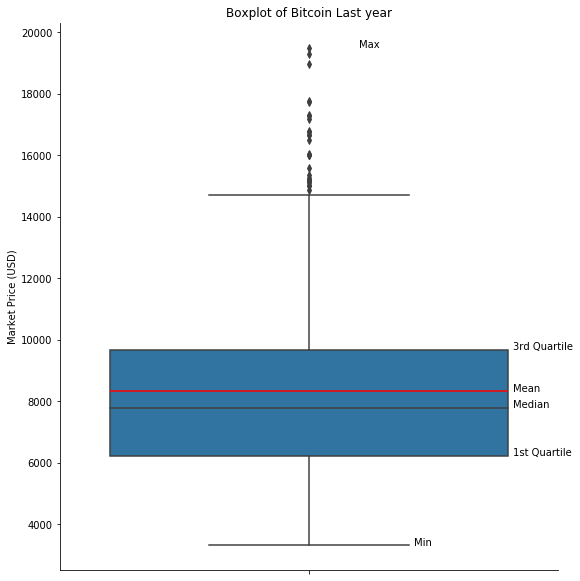

In [8]:
sns.factorplot(kind='box',        # Boxplot
               y='Market Price (USD)',       # Y-axis - values for boxplot
               data=chart_df,        # Dataframe 
               size=8,            # Figure size (x100px)      
               legend_out=False)  # Make legend inside the plot
plt.text(x=0.41, y=summary.values[6], s="3rd Quartile")
plt.text(x=0.41, y=summary.values[5], s="Median")
plt.text(x=0.41, y=summary.values[4], s="1st Quartile")
plt.text(x=0.21, y=summary.values[3], s="Min")
plt.text(x=0.1, y=summary.values[7], s="Max")
plt.text(x=.41, y=summary.values[1], s="Mean")
plt.hlines(y=summary.values[1], xmin=-.4, xmax=.4, colors='r')
plt.title('Boxplot of Bitcoin Last year');

So in the past year, the price of bitcoin has varied from a high of $\$$19498 to a low of $\$$3319, with a mean of $\$$8313 and a median at $\$$7786. It doesn't take a statistician to recognize the price has been extremely volatile. We can also deduce that our distribution may be skewed to the right as our median is lower than the mean. This can be seen on the boxplot, but there are better tools. Let's try drawing a distribution plot.

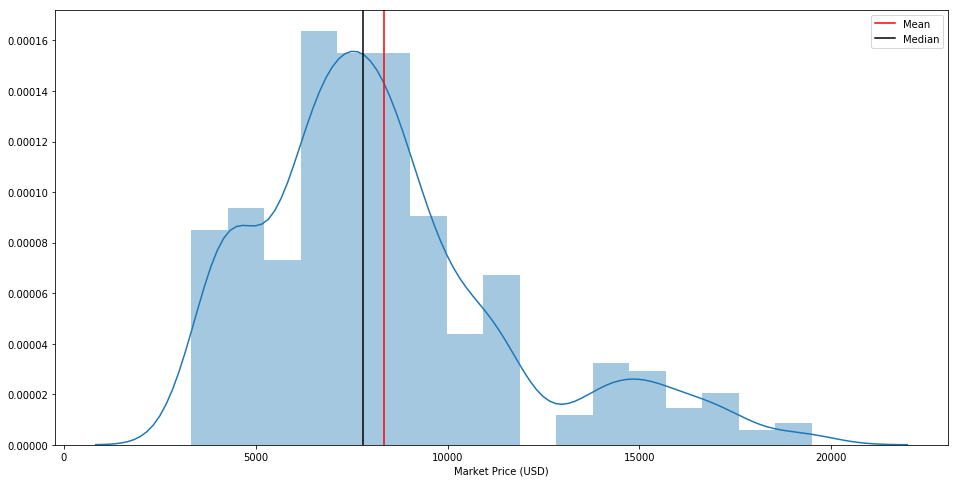

In [9]:
plt.figure(figsize=(16,8))
sns.distplot(chart_df['Market Price (USD)'])
plt.axvline(summary.values[1], color='r') # Mean
plt.axvline(summary.values[5], color='black') # Median
plt.legend(['Mean','Median']);

## Data Exploration: Testing For Normalcy
We can see that the bitcoin prices for the past year didn't follow a normal distribution. This is usually the case for financial data.
We could plot the rest of the distributions, but since we have a lot of columns it will be better to test them for normalcy and review the results.
For that we will use 3 separate tests ([Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro), [Anderson-Darling](), [D'Agostino's K-squared](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html))designed to identify normal distributions and place their results in a dataframe.

In [10]:
# null hypothesis: data comes from a normal distribution

# The Shapiro-Wilk test 
def SWtest(data):
    from scipy.stats import shapiro

    alpha = 0.001
    stat, p = shapiro(data)
    # interpret
    if p < alpha: 
        return 'Non-Normal' # The null hypothesis can be rejected
    else:
        return 'Normal' # The null hypothesis cannot be rejected

# Anderson-Darling Test
def ADtest(data):
    from scipy.stats import anderson

    result = anderson(data)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        # interpret
        if result.statistic < result.critical_values[i]:
            return 'Normal' # The null hypothesis cannot be rejected
        else:
            return 'Non-Normal' # The null hypothesis can be rejected

# D'Agostino's K-squared test
def ksquared(data):
    from scipy.stats import normaltest

    alpha = 1e-3
    stat, p = normaltest(data)
    # interpret
#     print("p = {:g}".format(p))
    if p < alpha: # null hypothesis: data comes from a normal distribution
        return 'Non-Normal' # The null hypothesis can be rejected
    else:
        return 'Normal' # The null hypothesis cannot be rejected

# Aggregate dataframe across a list of functions returning a new dataframe with results of functions. 
# In this case we will see our distributions being tested for normalcy using 3 separate tests.
normalcy_df = chart_df.aggregate([SWtest, ADtest, ksquared], axis=0)
normalcy_df.transpose() # Transpose for easier readability

,SWtest,ADtest,ksquared
Bitcoins in circulation,Non-Normal,Non-Normal,Non-Normal
USD Exchange Trade Volume,Non-Normal,Non-Normal,Non-Normal
Market Price (USD),Non-Normal,Non-Normal,Non-Normal
Market Capitalization,Non-Normal,Non-Normal,Non-Normal
Blockchain Size,Non-Normal,Non-Normal,Non-Normal
Average Block Size,Non-Normal,Non-Normal,Non-Normal
Average Number Of Transactions Per Block,Non-Normal,Non-Normal,Non-Normal
Median Confirmation Time,Non-Normal,Non-Normal,Non-Normal
Hash Rate,Non-Normal,Non-Normal,Non-Normal
Difficulty,Non-Normal,Non-Normal,Non-Normal


As you can see from the table above, every column has been labeled as **Non-Normal** meaning there is a high probability these distributions are not normally distributed.  As a result we would need to conduct our analysis using **Non-Parametric tests**. **Non-Parametric** does not imply these datasets are without parameters, but that the number and nature of their parameters are flexible and not known in advance. This is normally true for all continuous, time-series data sets, but it's good to verify.

In todays world of finance, some analysts (un)-knowingly use financial data assuming a normal distribution. They build their models based on these assumptions and as a result their portfolios are misrepresented and inaccurate. Assuming a normal distribution can be attractive, because it can help us describe our data clearly, but a clear view is no good if it's perspectively non-representative. It's kinda like forecasting the weather outside through a window, only that window is transparent once a day.

Ever wonder how some banks go bankrupt? Their models are based on normal distributions and often misrepresent their portfolios real risk. To give you an example, take a look at how options are [priced](https://www.investopedia.com/articles/optioninvestor/07/options_beat_market.asp). In short, they use the [Black-Scholes](https://www.investopedia.com/terms/b/blackscholes.asp) Formula to determine the **Parameters** of the option. To do this, they make several assumptions: dividends, risk-free rates and volatility are **constant** which as we will see is certainly not the case. 

I could go on about the misrepresentations of markets, but I digress. If you're interested in learning more you can read up on [Benoit Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot#Randomness_in_financial_markets). He's well known for his fractal geometry including the most famous "Mandelbrot set". In his book ["The (Mis)behavior of Markets"](https://www.amazon.com/Misbehavior-Markets-Fractal-Financial-Turbulence/dp/0465043577) he goes into great depth and detail about the misrepresented markets we assume are being correctly portrayed. I mean, banks attract some of the brightest mathematicians and engineers around the world. How could they possibly be doing something so wrong, for so long?

Some analysts find better distributions when analyzing their financial data on the logarithmic scale. This makes sense for analysis purposes, because a price change from $\$$1 to $\$$100 is a lot different than a change of $\$$10001 to $\$$10100. Also, prices can never be negative.

For now let's continue our exploration of the data and look into using the logarithmic function to see if we can transform our non-normal distributions into normal ones.

In [16]:
log_chart_df = chart_df.apply(np.log, 0)
summary = log_chart_df['Market Price (USD)'].describe();
summary

count    359.000000
mean       8.953299
std        0.385405
min        8.107609
25%        8.739165
50%        8.960196
75%        9.176565
max        9.878102
Name: Market Price (USD), dtype: float64

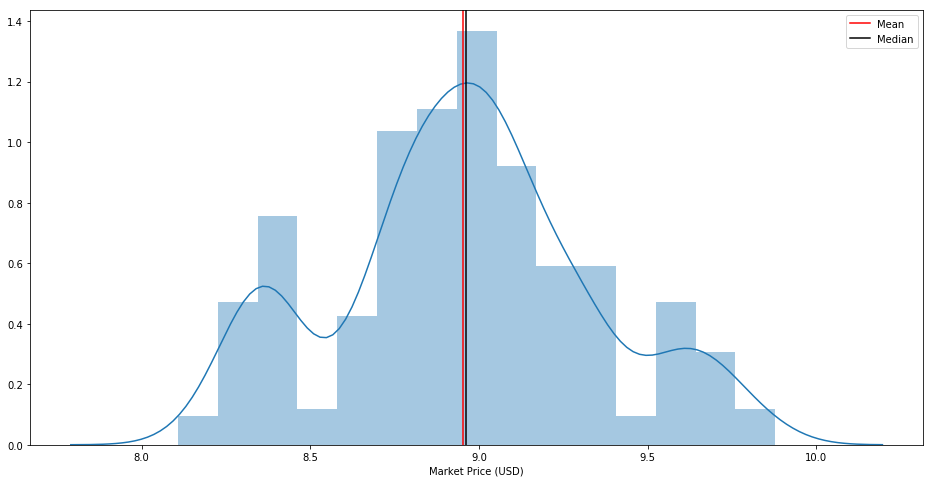

In [14]:
# Using Logarithmic transformation to normalize distribution
plt.figure(figsize=(16,8))
sns.distplot(log_chart_df['Market Price (USD)'])
plt.axvline(summary.values[1], color='r') # Mean
plt.axvline(summary.values[5], color='black') # Median
plt.legend(['Mean','Median']);

This distribution looks a little better on a logarithmic scale. See how the Mean and Median are centered.

Now, lets run the rest of our logarithmic data through our normalcy test functions.

In [17]:
# Logarithmic Transformation Normalcy Testing
log_normalcy_df = log_chart_df.aggregate([SWtest, ADtest, ksquared], axis=0)
log_normalcy_df.transpose() # Transpose for easier readability

,SWtest,ADtest,ksquared
Bitcoins in circulation,Non-Normal,Non-Normal,Non-Normal
USD Exchange Trade Volume,Normal,Normal,Normal
Market Price (USD),Non-Normal,Non-Normal,Normal
Market Capitalization,Non-Normal,Non-Normal,Normal
Blockchain Size,Non-Normal,Non-Normal,Non-Normal
Average Block Size,Non-Normal,Non-Normal,Non-Normal
Average Number Of Transactions Per Block,Non-Normal,Non-Normal,Non-Normal
Median Confirmation Time,Normal,Normal,Normal
Hash Rate,Non-Normal,Non-Normal,Non-Normal
Difficulty,Non-Normal,Non-Normal,Non-Normal


We got slightly different results using the logarithmic scale. The only columns that passed all three tests were **USD Exchange Trade Volume** and **Median Confirmation Time**, others had mixed results, and unless they pass all the tests they will remain Non-Normal.

We have a few options from here:
* We can investigate these Non-Normal distributions and try cleaning up the data in order to attain a normal distribution.
* We can continue our analysis with the least amount of assumptions for our data and perform non-parametric tests across all distributions except the 2 that passed with logarithmic transformations.
* We can investigate only the distributions we think will actually be significant, by looking for correlations and using our intuition.

I like the last option, because it gives us a chance at feature selecting before we do any unnecessary work on features that may not matter.

## Data Exploration: Looking at Distributions

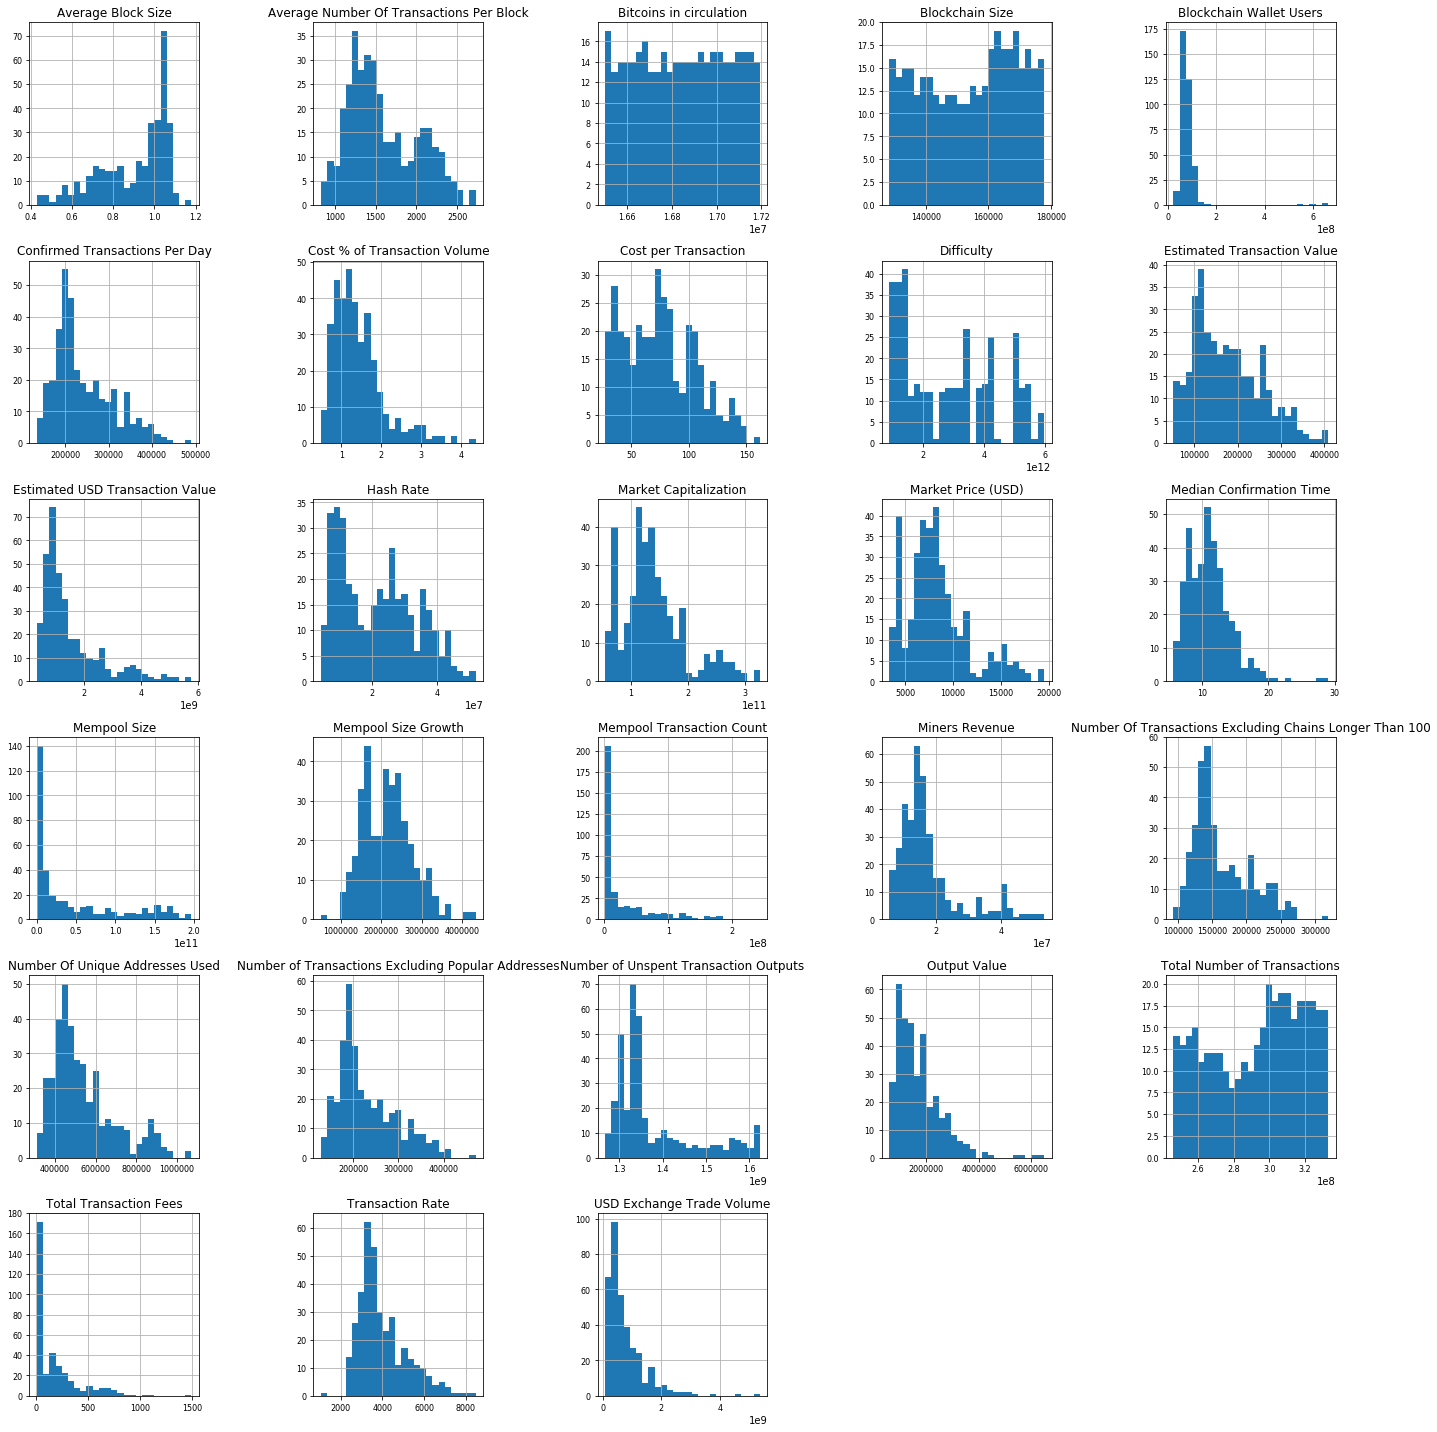

In [19]:
# Here's some plots of all the distributions 
chart_df.hist(figsize=(20, 20), bins=25, xlabelsize=8, ylabelsize=8)
plt.tight_layout()

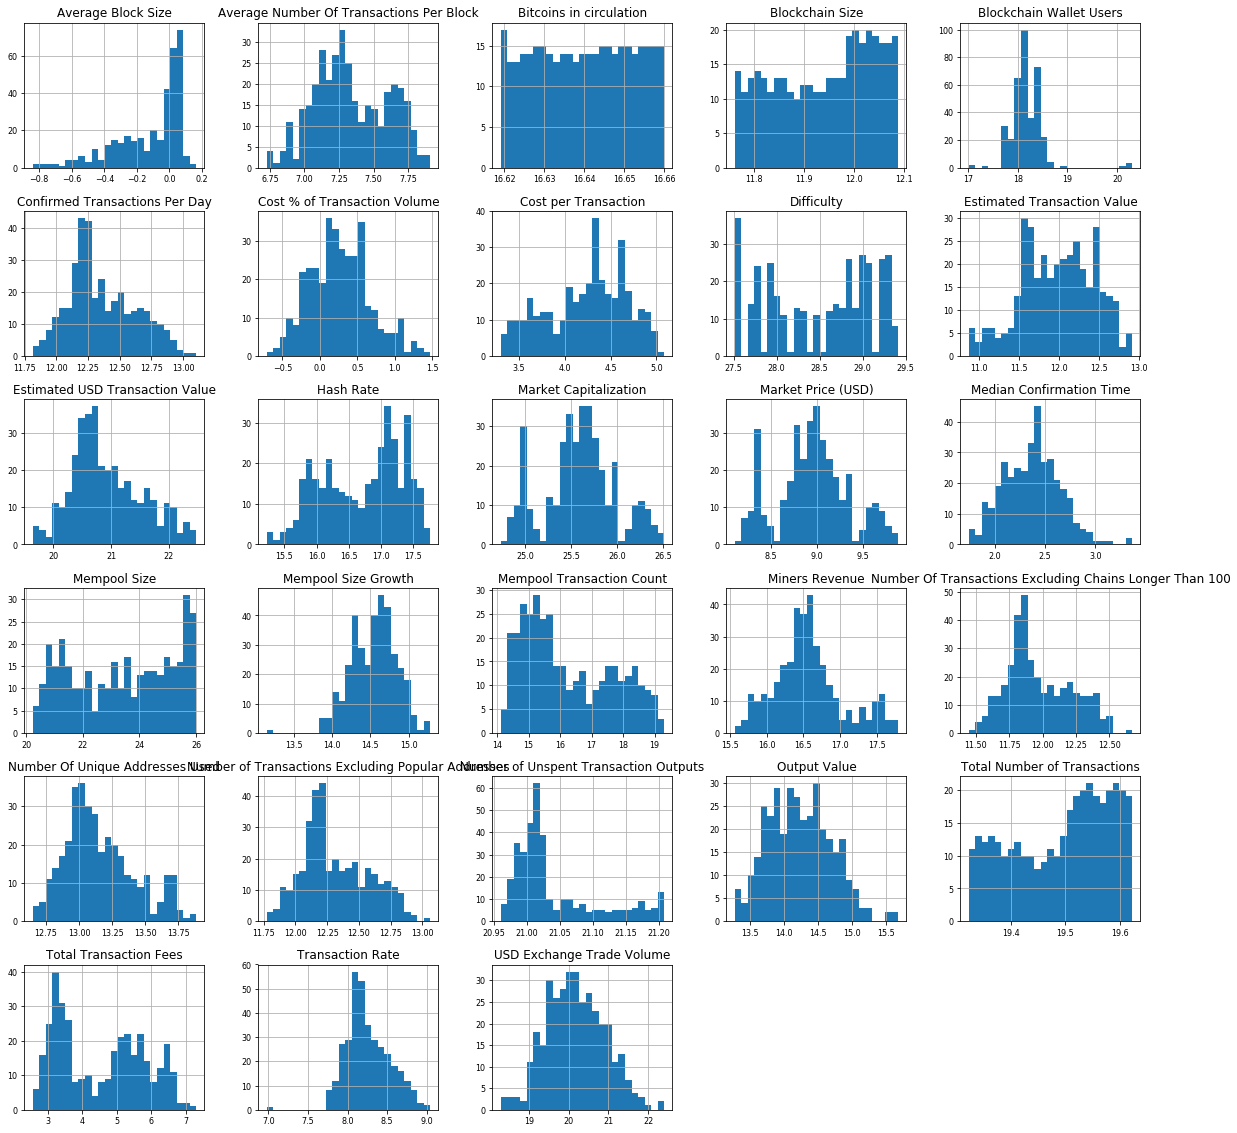

In [15]:
# Now here's a plot of the same data, but transformed logarithmically.
log_chart_df.hist(figsize=(20, 20), bins=25, xlabelsize=8, ylabelsize=8);

By plotting the histogram we can visually see each variables yearly distribution. The Log distributions look more normal and a few have some outliers we might be able to clean up.

We can also look at correlations using the Pearson method which is conveniently built in to the pandas dataframe. Remember, the Pearson method assumes a normal distribution, so these results can't be trusted. At most they will give us cursory correlations, which should be enough for general exploration.

In [20]:
corr_df = chart_df.corr()['Market Price (USD)']
features = corr_df[abs(corr_df) > 0.5].sort_values(ascending=False)[1:] # Omitting Market Price itself
print("There are {} strongly correlated values with Market Price:\n{}\n".format(len(features), features))

# Same thing, but with Log
corr_df = log_chart_df.corr()['Market Price (USD)']
log_features = corr_df[abs(corr_df) > 0.5].sort_values(ascending=False)[1:] # Omitting Market Price itself
print("There are {} strongly logarithmic correlated values with Market Price:\n{}".format(len(log_features), log_features))

There are 8 strongly correlated values with Market Price:
Market Capitalization              0.999586
Miners Revenue                     0.960317
Cost per Transaction               0.848546
Estimated USD Transaction Value    0.800518
USD Exchange Trade Volume          0.668254
Number Of Unique Addresses Used    0.549839
Total Transaction Fees             0.539118
Mempool Size                      -0.500757
Name: Market Price (USD), dtype: float64

There are 7 strongly logarithmic correlated values with Market Price:
Market Capitalization                    0.999383
Miners Revenue                           0.953731
Cost per Transaction                     0.885846
USD Exchange Trade Volume                0.697773
Estimated USD Transaction Value          0.672205
Mempool Size                            -0.594279
Number of Unspent Transaction Outputs   -0.604972
Name: Market Price (USD), dtype: float64


For what it's worth these correlations look pretty solid. Market Capitalization should be close to 1 and it is. Our Log transformation is similar, but drops **Total Transaction Fees** and **Number Of Unique Addresses Used** for **Number of Unspent Transaction Outputs** 

Let's continue investigating correlations from another perspective and keep our eyes peeled for any outliers or other strange data points affecting distributions.

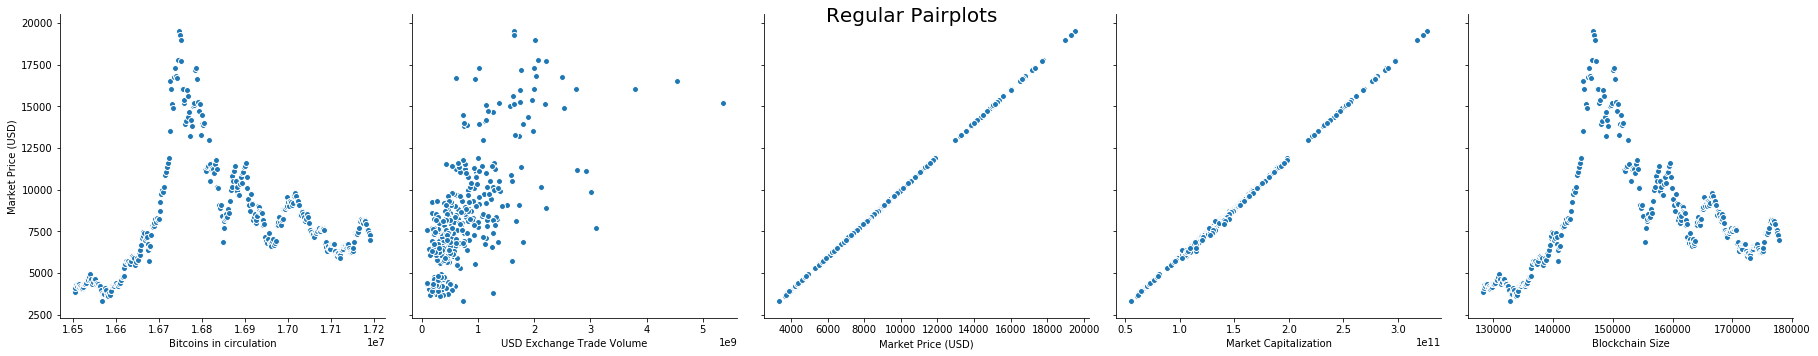

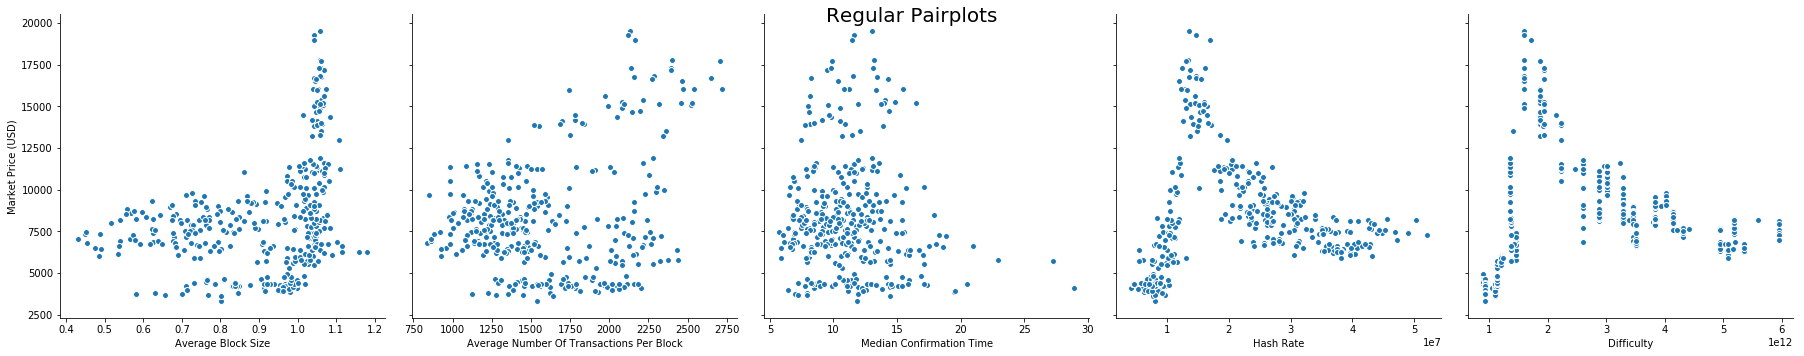

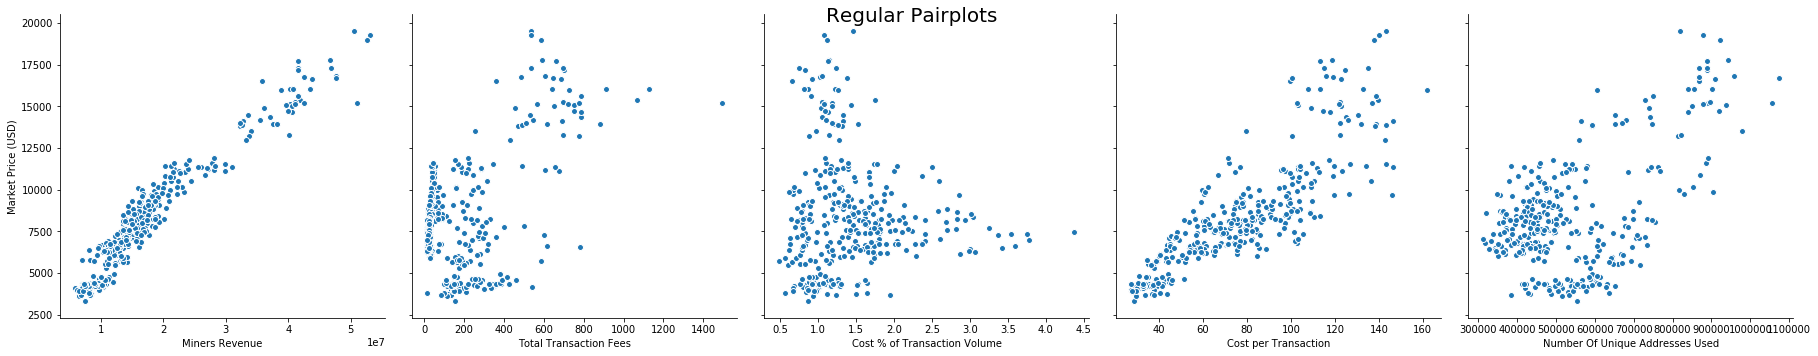

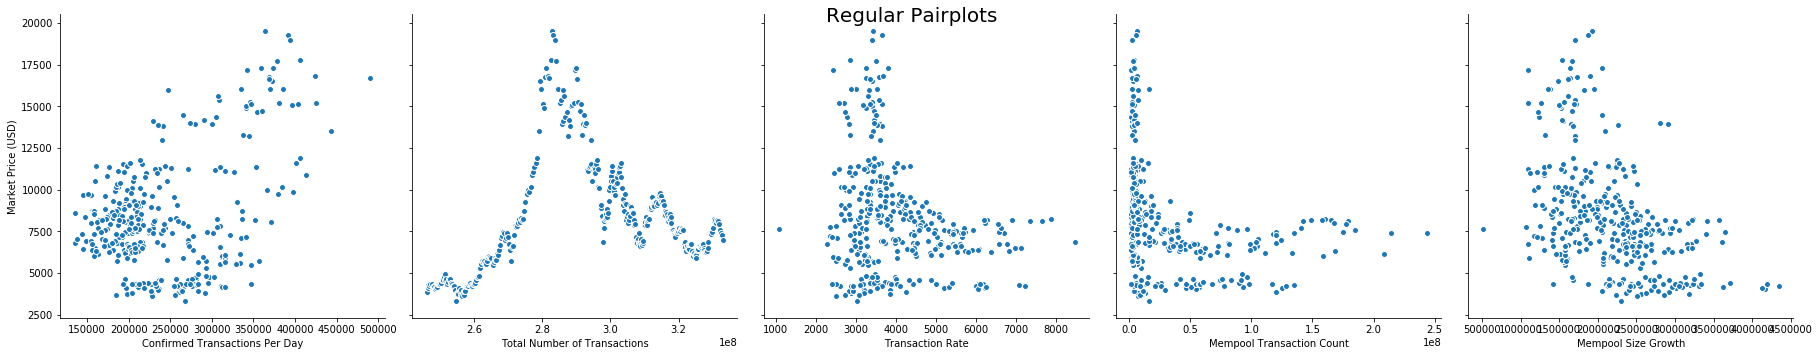

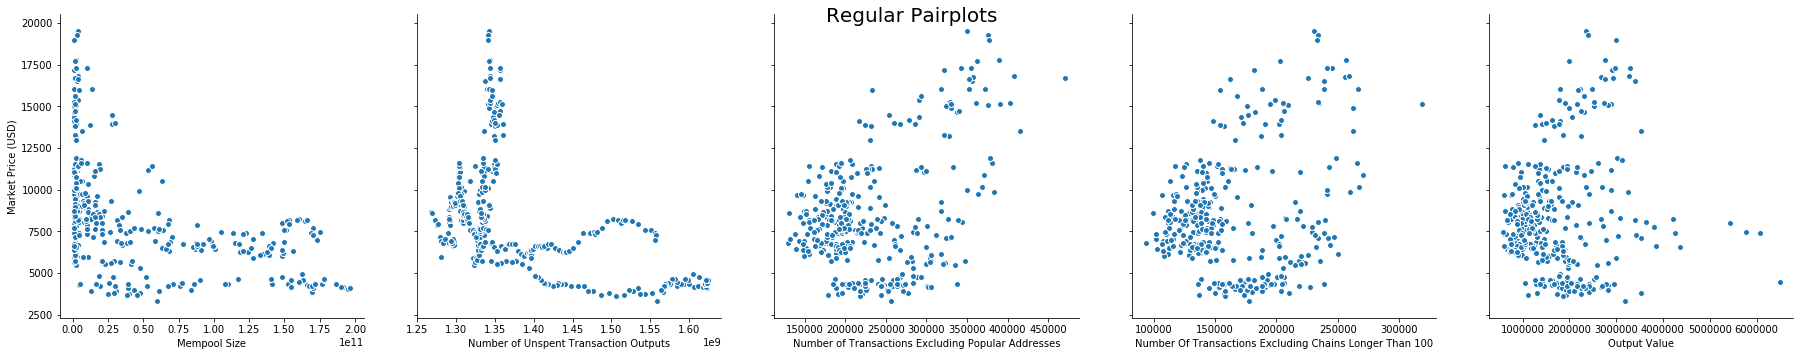

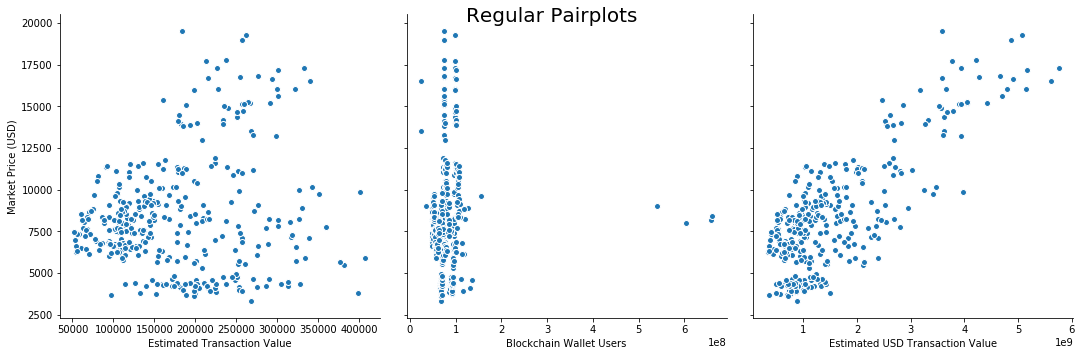

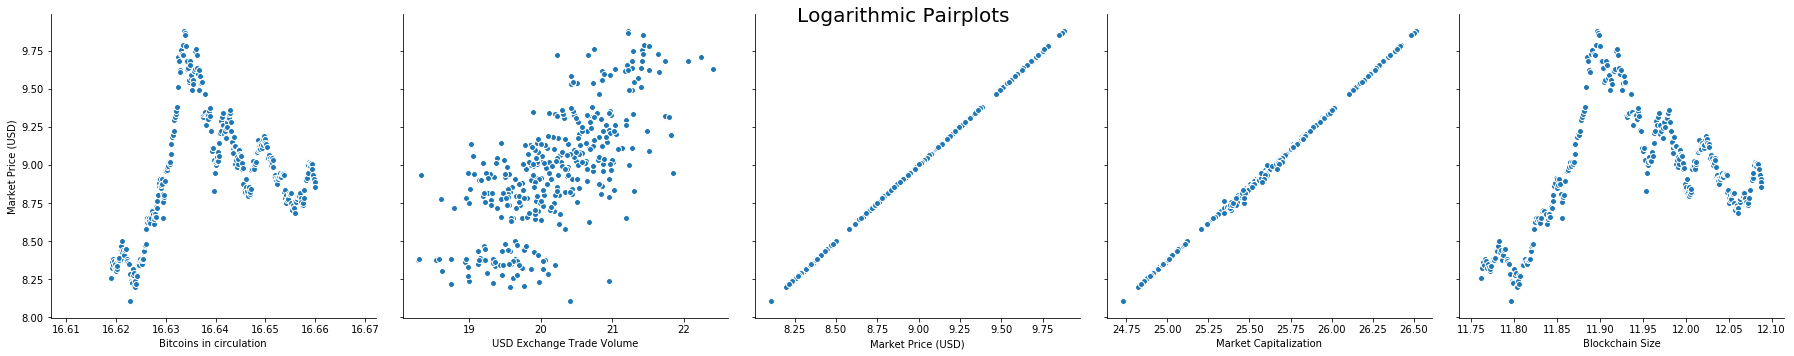

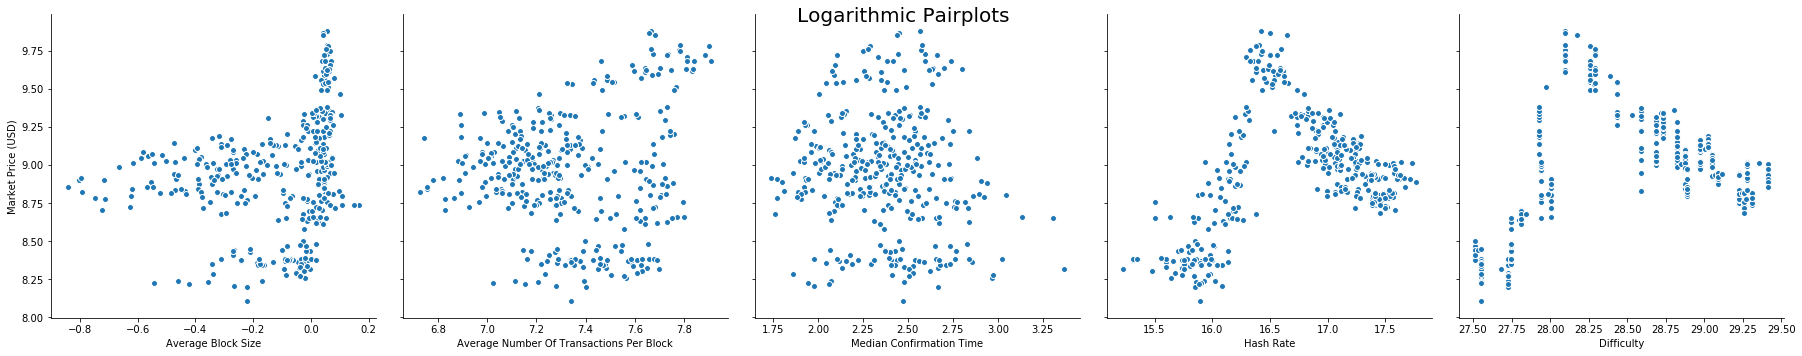

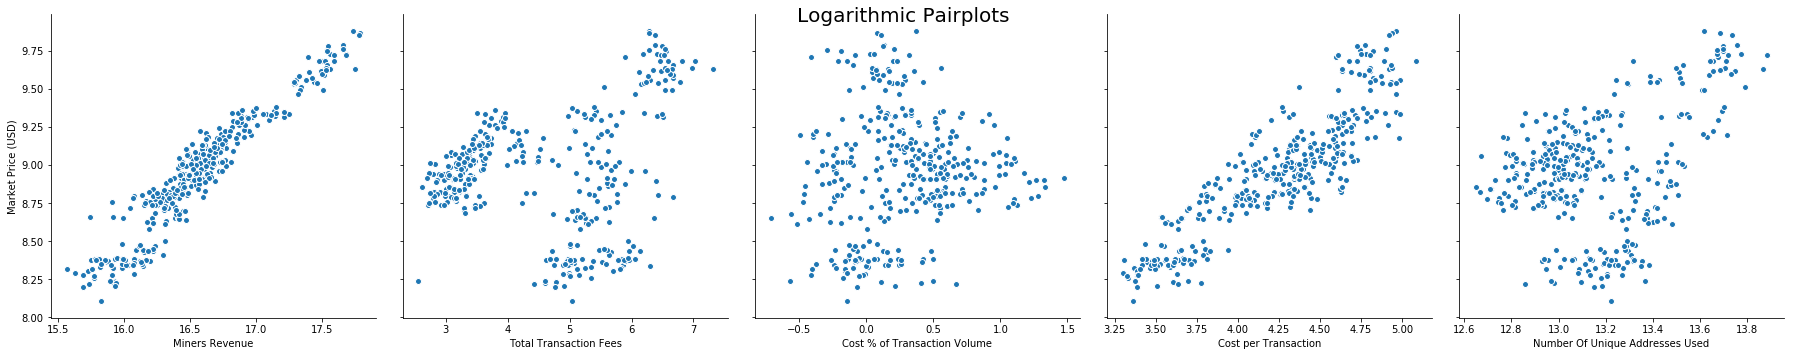

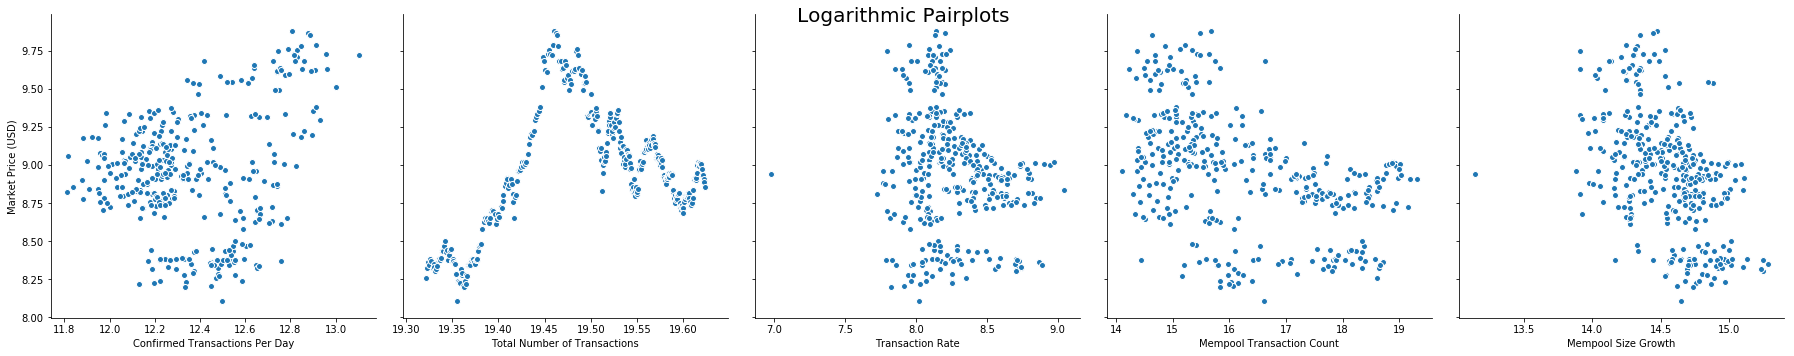

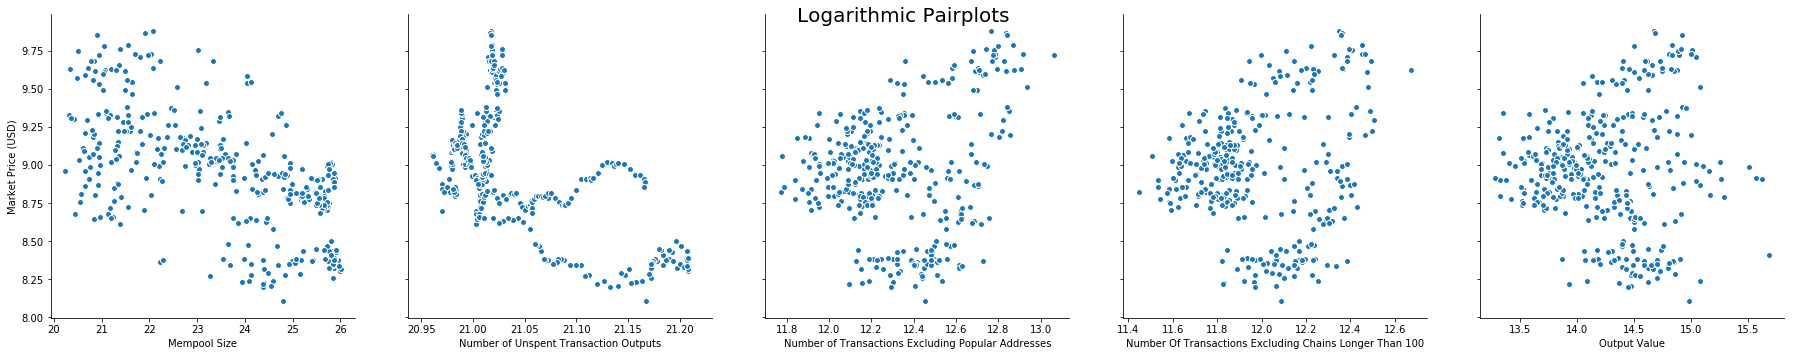

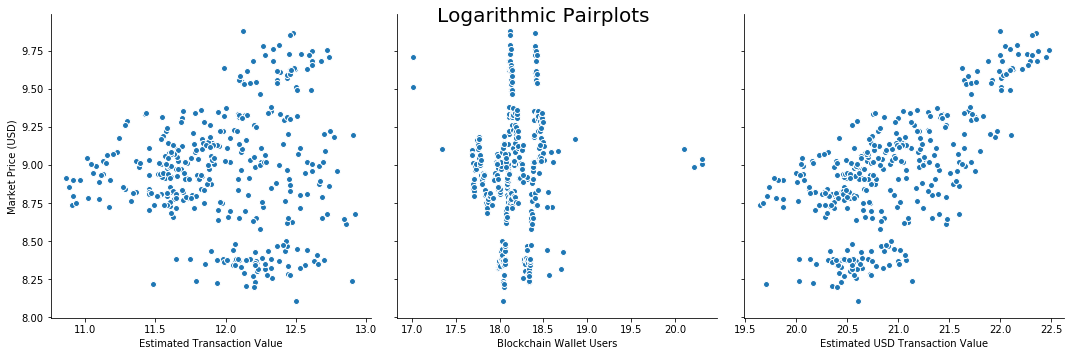

In [32]:
# Plot pairplot against Market Price USD
for i in range(0, len(chart_df.columns), 5):
    sns.pairplot(data=chart_df,
                x_vars=chart_df.columns[i:i+5],
                y_vars=['Market Price (USD)'],
                size=5
                ).fig.suptitle('Regular Pairplots', size=20)

# And we can do the same thing with our log dataframe
for i in range(0, len(log_chart_df.columns), 5):
    sns.pairplot(data=log_chart_df,
                x_vars=log_chart_df.columns[i:i+5],
                y_vars=['Market Price (USD)'],
                size=5
                ).fig.suptitle('Logarithmic Pairplots', size=20)

Here's what looks interesting:

* **Average Number of Transactions Per Block maximums**.

    Looking at this pairplot closely it's noticeable enough to point out that only when bitcoin Market Price was above 15000, the average # of transactions exceeded 2500. This could be a future leading indicator by looking at the maximum leading values we can detect market sentiment. Though there are probably better ways of achieving the same result. Like using google trends.

* **[Estimated USD Transaction Value](https://www.blockchain.com/charts/estimated-transaction-volume-usd) Correlates with the market price**.

    This may only be due to the redundant properties of USD Volume to USD Price Conversion. It might be more meaningful to look at the volume of actual bitcoin being traded against the USD price or vise versa.
We can see this pairplot by looking at the **Estimated Transaction Value** which is *"the total estimated value of transactions on the Bitcoin blockchain (does not include coins returned to sender as change)."* [Source](https://www.blockchain.com/charts/estimated-transaction-volume) There doesn't seem to be any correlation between "Market Price (USD)" and the amount of bitcoins being transacted across the blockchain. However, we'll keep volume in our features list because intuitively we know it as an effect on market price. It's unique in that it has two vectors and in a future analysis we should separate the volume into bid and ask volumes in order to infer a more causal relationship with price. 

* **Total Transaction Fees**.

    This looks correlated if we remove a few outliers.
 
* **Confirmed Transactions Per Day**.

    Also looks correlated. There are 2 other charts very similar to this one. They exclude popular addresses and long chains, but the data doesn't really look any different. Take a look at 'Total Number of Transactions per Day Excluding.." 

* **Mempool Transaction Count**.

    Could look more interesting if we removed all the values clustered near zero.

* **Average Block Size Clusters around 1.** 
    
    This is because there is a 1MB limit on the blocksize. It would be interesting to remove those points and look at the times when the blocks weren't full.


 Notes:

* **Market Capitalization and Market Price (USD)** are extremely correlated, but we don't gain any extra information by understanding this correlation because the only parameter in this relationship is market price. In the future we could compute our own Market Capitalization based off of the amount of mined bitcoins times Market Price, currently the equation takes all 21 million BTC into account. For now well just remove market cap. Below we have a list of our features for now. We can always come back and look at some of the other interesting relationships later if we need more data.
 
 
 We'll use our new list of features to plot a correlation heatmap to better understand their relationships.

## Data Exploration: Feature to Feature Relationship
Below we will plot a correlation heatmap with the variables we decided might affect bitcoins price.

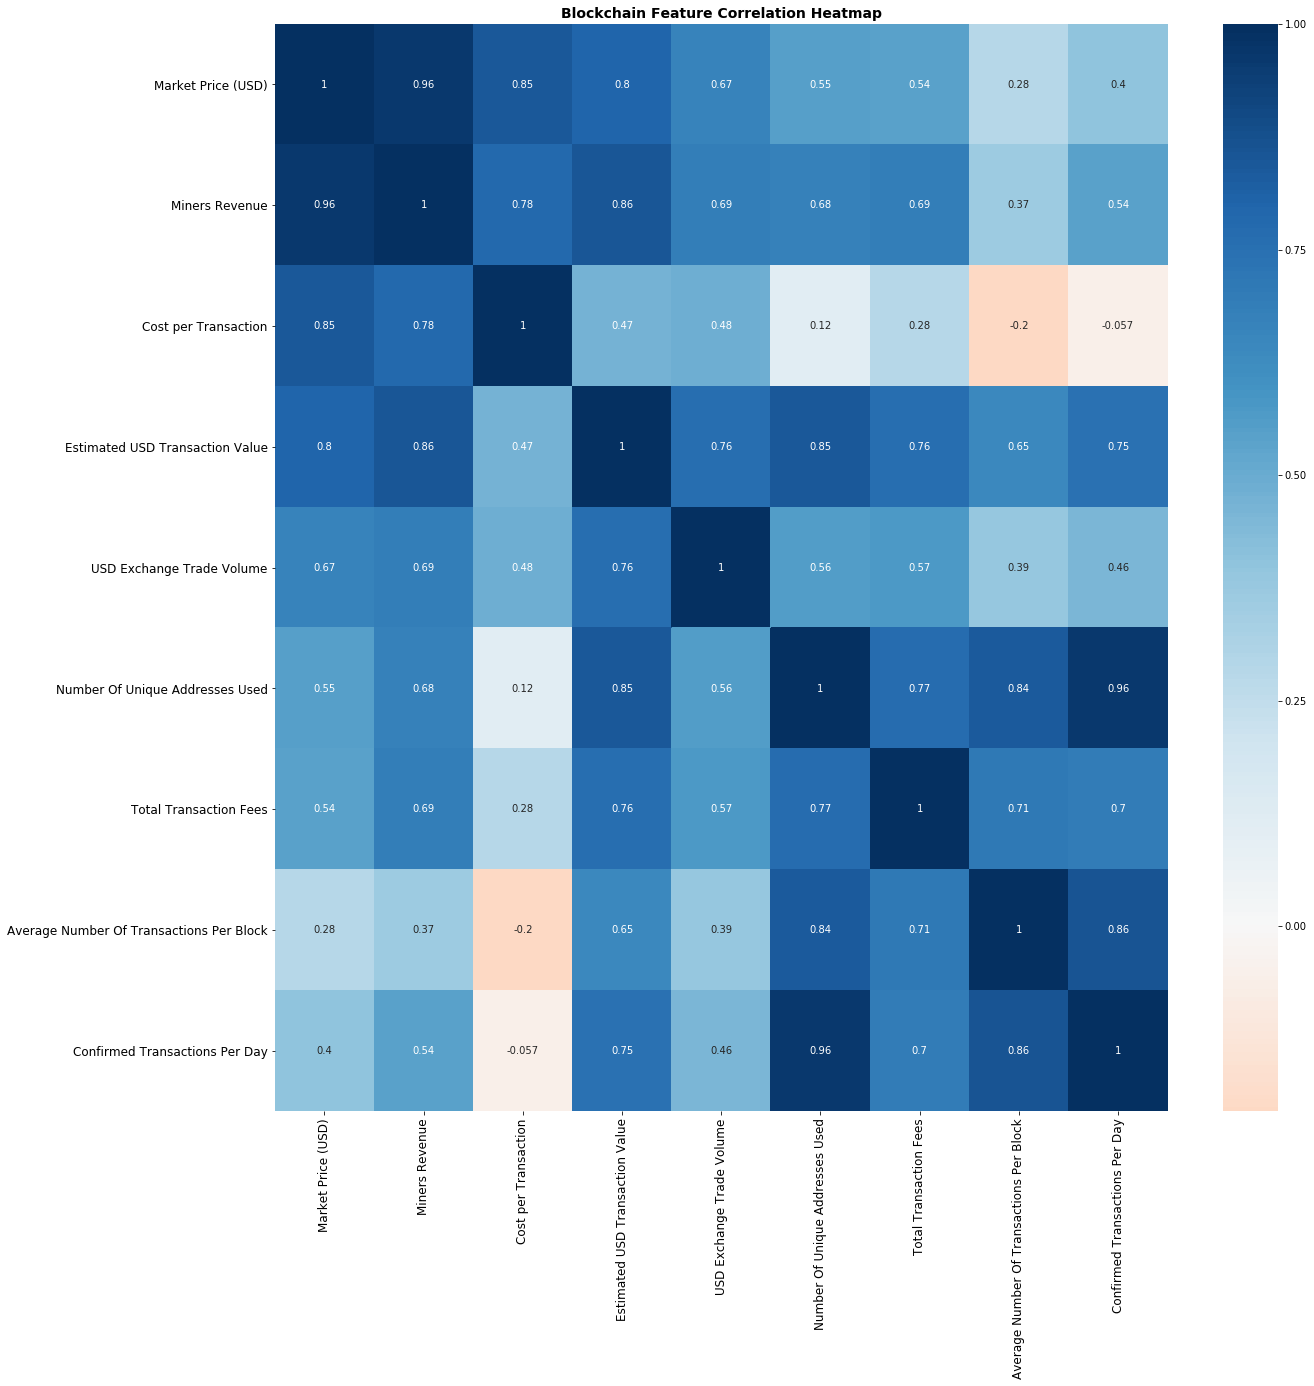

In [24]:
# Market Price isn't a feature, but we'll keep it in this list so we can visualize it with the rest of the features
features = ['Market Price (USD)',
            'Miners Revenue',
            'Cost per Transaction',
            'Estimated USD Transaction Value',
            'USD Exchange Trade Volume',
            'Number Of Unique Addresses Used',
            'Total Transaction Fees',
            'Average Number Of Transactions Per Block',
            'Confirmed Transactions Per Day']

plt.figure(figsize=(20,20))
plt.title('Blockchain Feature Correlation Heatmap', size=14, weight='bold')
plt.xticks(size=12)
plt.yticks(size=12)
sns.heatmap(chart_df[features].corr(), annot=True, center=0, cmap="RdBu");

* It's very interesting to see the strong correlation between **Miners Revenue** *and* **Market Price**, most importantly the comparison between each variables subsequent relationships. In some ways Miners Revenue has stronger correlations with several other variables. This might be helpful later on when we build our model. We can get rid of any redundant features.

* We can also see a very strong correlation between **Confirmed Transactions Per Day** *and* **Number of Unique Addresses Used**

I'm not sure how much merit it holds, but just for fun let's take a look at which variable has the strongest sum of correlations.

In [25]:
print("\n   Categories With Strongest Sum of Correlations: Descending")
abs(chart_df.corr()).sum().sort_values(ascending=False)


   Categories With Strongest Sum of Correlations: Descending


Number Of Unique Addresses Used                            15.448421
Estimated USD Transaction Value                            14.948162
Number of Transactions Excluding Popular Addresses         14.935202
Confirmed Transactions Per Day                             14.878534
Number Of Transactions Excluding Chains Longer Than 100    14.782223
Average Number Of Transactions Per Block                   14.583493
Estimated Transaction Value                                14.535077
Difficulty                                                 13.991388
Total Transaction Fees                                     13.972031
Hash Rate                                                  13.902395
Blockchain Size                                            13.402799
Bitcoins in circulation                                    13.384372
Total Number of Transactions                               13.154308
Output Value                                               12.551859
Cost % of Transaction Volume      

It's interesting to see our dependent variable **Market Price** relatively low in it's total correlation with the rest of the blockchain. I'm not sure how else to interpret this, but i'll leave it just in case someone else finds it useful.

Ok, before we go further we need to understand that time-series correlations are dynamic and change over time. So we need to look at the rolling correlations and see how variable they are. We'll use our features list to plot a rolling correlation with Market Price.

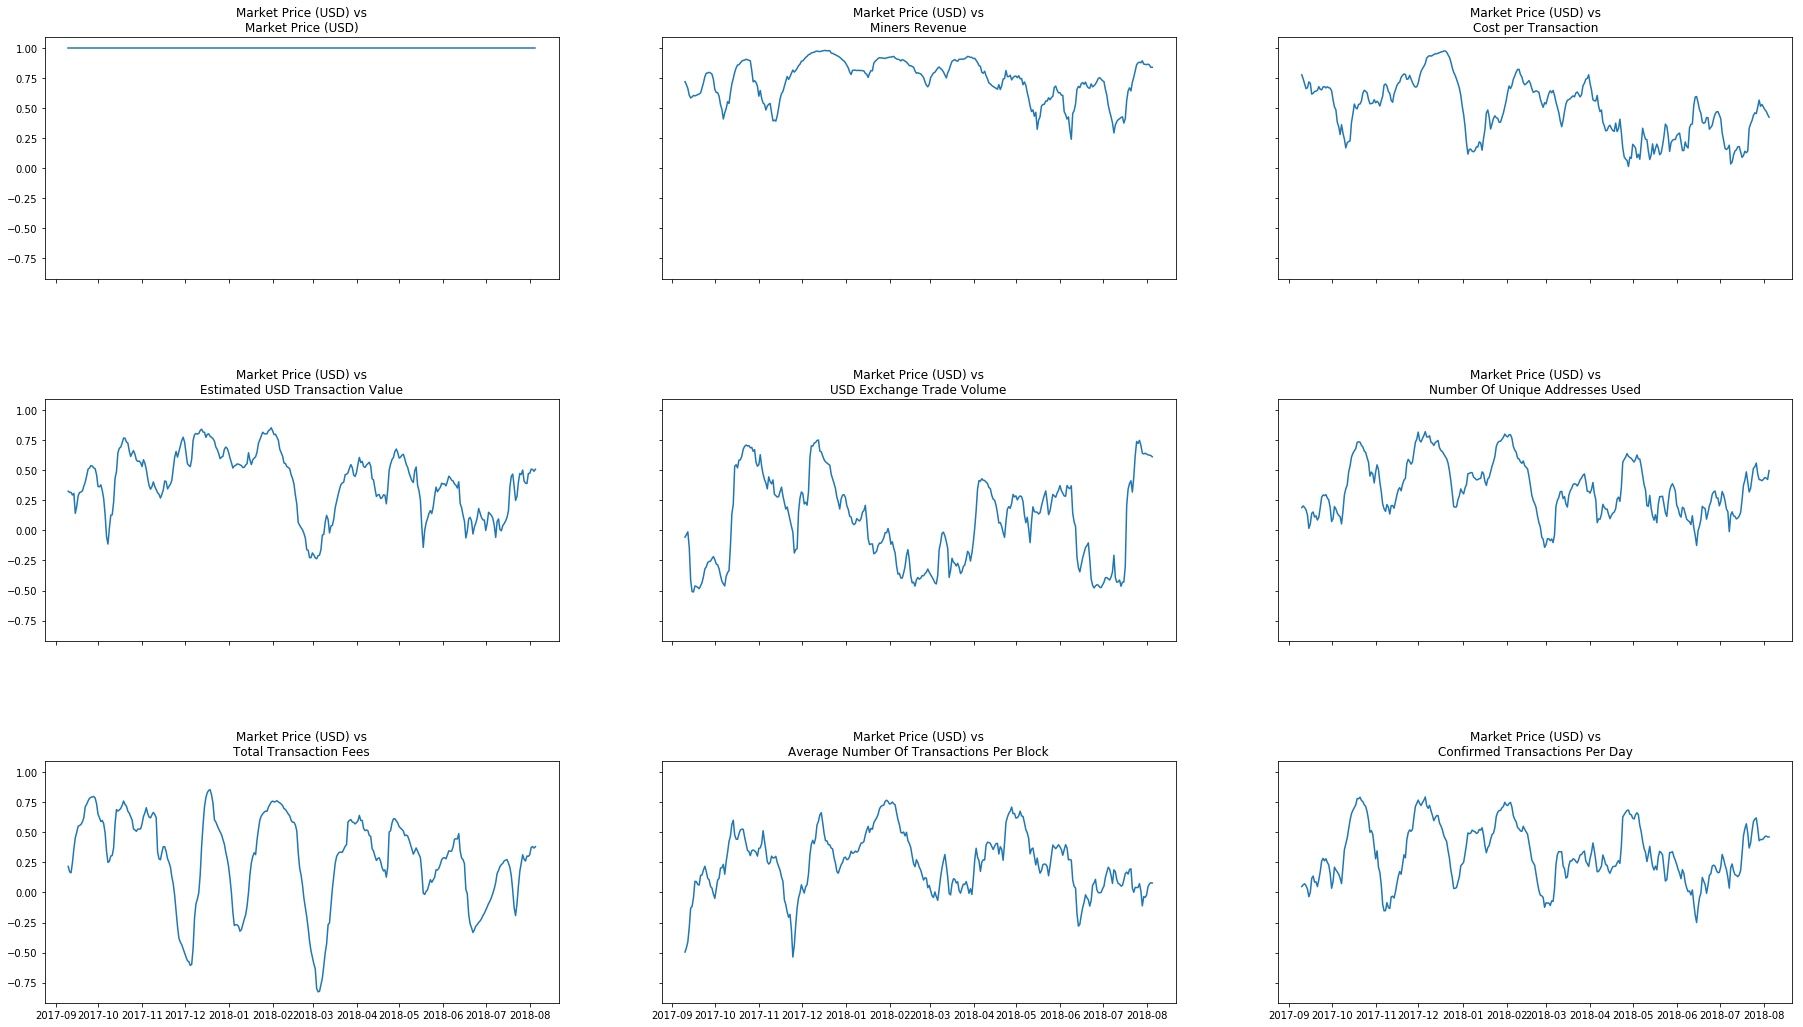

In [26]:
fig, ax = plt.subplots(round(len(chart_df[features].columns)/3), 3,
                       figsize=(25, 14), sharex=True, sharey=True)
column = 0
row = 0
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.2)
for key, value in enumerate(chart_df[features]):
    if key < len(features):
        ax[row, column].set_title('{} vs\n{}'.format(
            'Market Price (USD)', features[key]))
        ax[row, column].plot(chart_df['Market Price (USD)'].rolling(
            window=30).corr(chart_df[features[key]]))  # We use a 30 day window to compute the correlation every month
        column += 1
        if column > 2:
            column = 0
            row += 1

Well it looks like there is a lot of variability in our correlations on a month to month basis. **Miners Revenue** is the only one that stays positive through the entire time-frame. We wouldn't expect Volume to stay positive because it can move price either way. We'll have to analyze that separately using different data in another post.

It's also interesting to point how some of the rolling correlations are similar to others. Naturally, I want to take a look at the correlation of our rolling correlations.

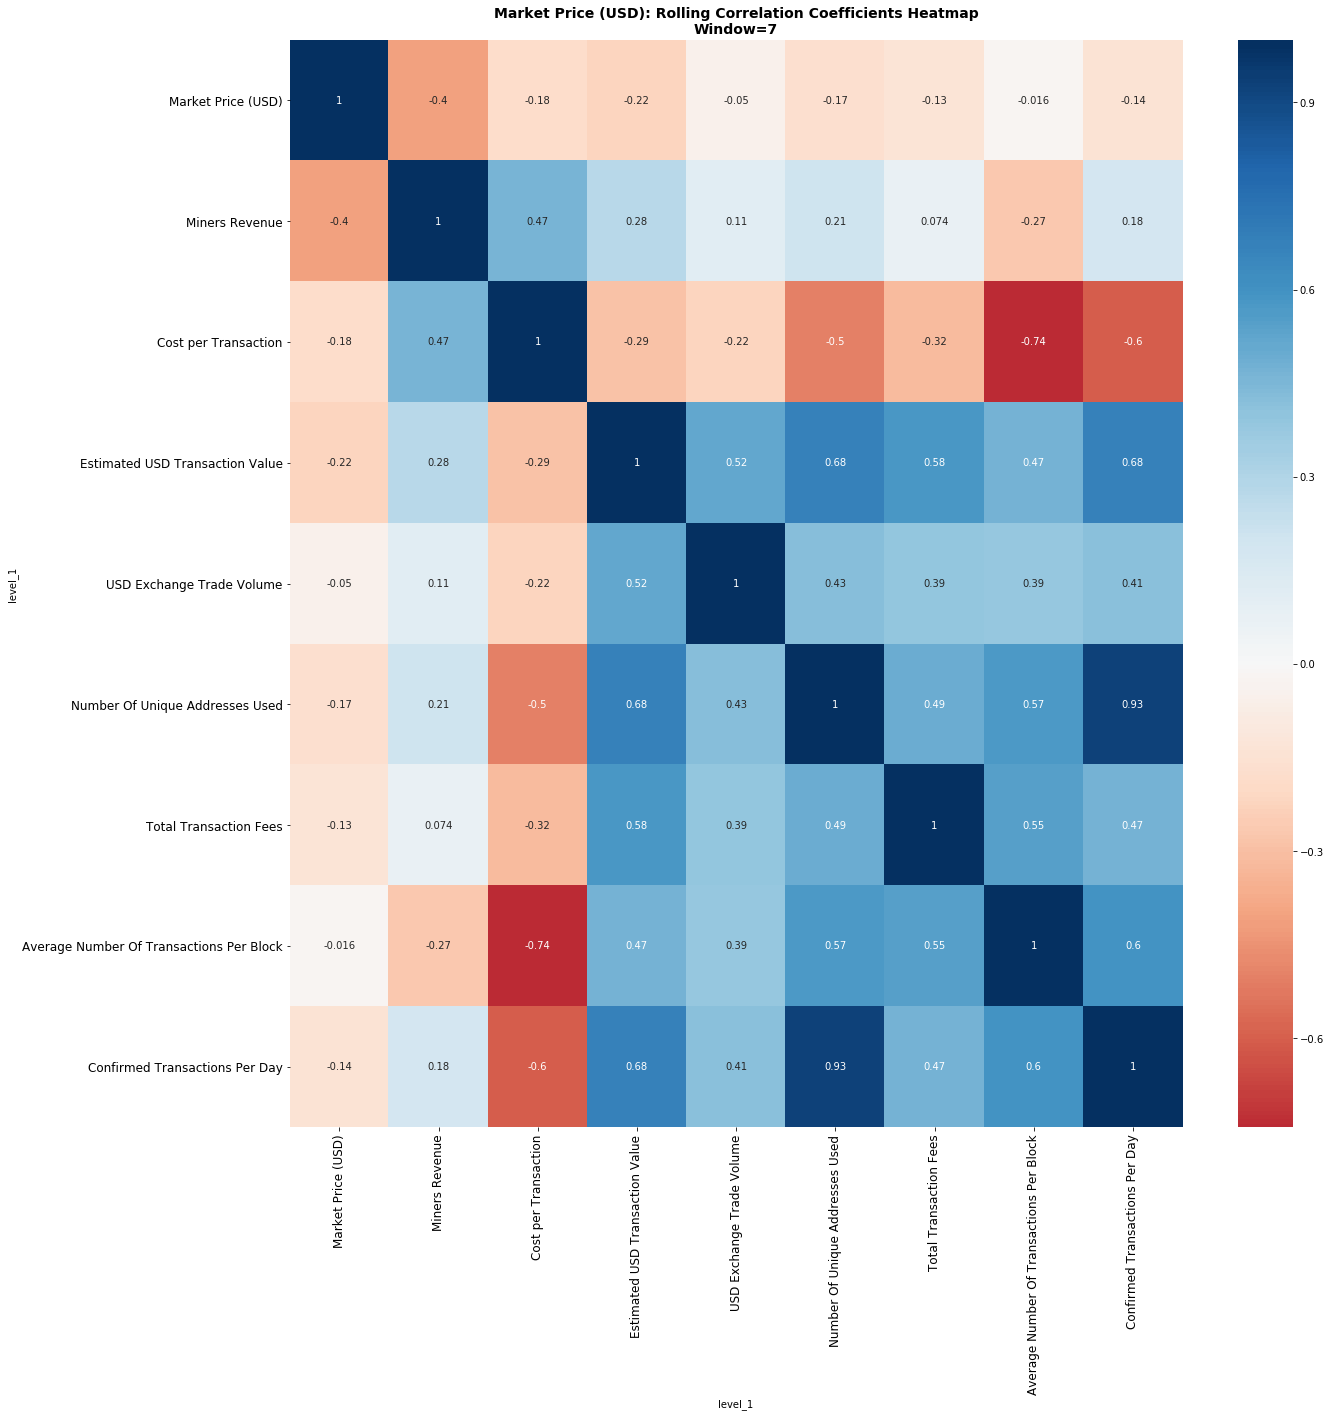

In [27]:
# Compute all the rolling correlations of our features against Market Price (USD) and return a DF

# This is the lookback period for the moving correlation. If you mess with the window size here, the results vary a lot.
window = 7
roll_corr = chart_df.rolling(window=window).corr()
roll_corr_df = roll_corr.reset_index().pivot(index='level_0', columns='level_1',
                                             values='Market Price (USD)').dropna()
# Plot a heatmap of rolling correlation correlations
plt.figure(figsize=(20, 20))
plt.title('Market Price (USD): Rolling Correlation Coefficients Heatmap\nWindow={}'.format(window),
          size=14, weight='bold')
plt.xticks(size=12)
plt.yticks(size=12)
sns.heatmap(roll_corr_df[features].corr(), annot=True, center=0, cmap="RdBu");

Well, that doesn't look so good anymore... I tried experimenting with different window values. The larger the window the smoother the correlations become, which is ok to a certain degree. Too large and we run he risk of overfitting. It's at 7 right now, representative of a week.

Let's look at the rest of the data.

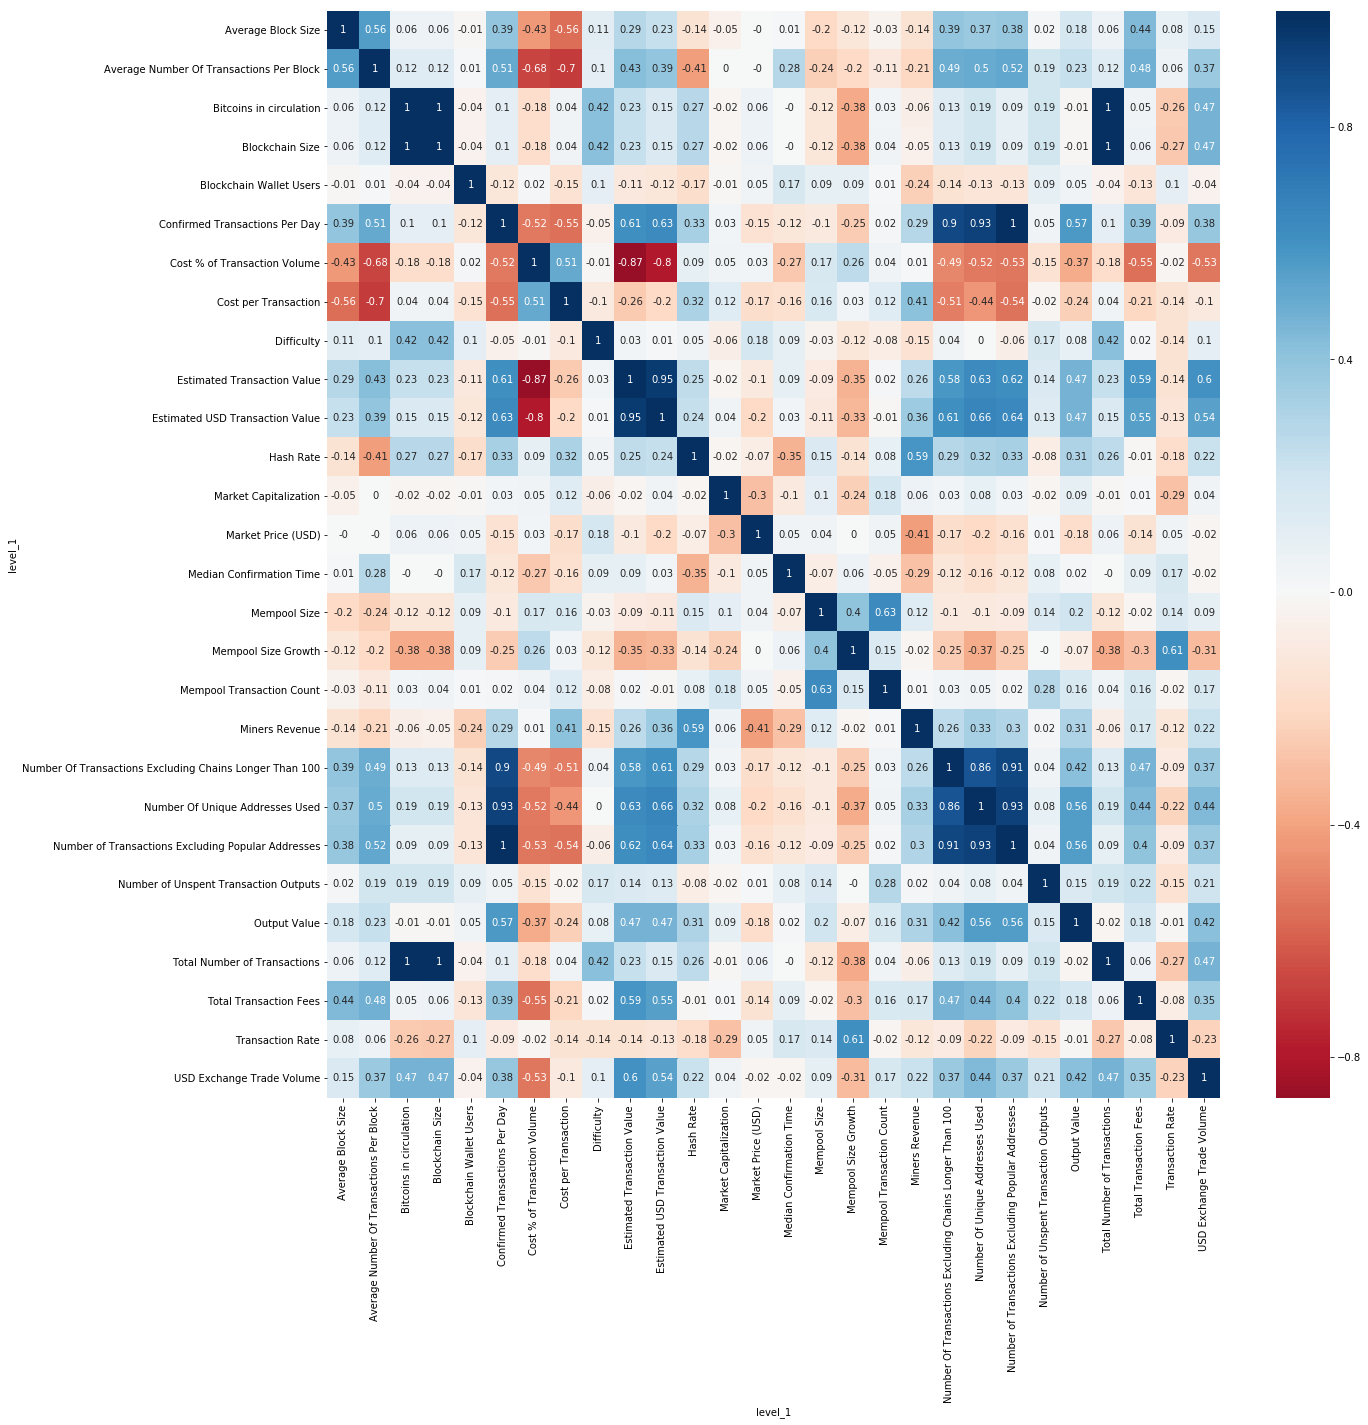

In [28]:
# Plot a heatmap of ALL the data against Market Price (USD)
all_roll_corr_df = roll_corr.reset_index().pivot(index='level_0', columns='level_1').dropna()
plt.figure(figsize=(20,20))
sns.heatmap(round(all_roll_corr_df['Market Price (USD)'].corr(),2), annot=True, center=0, cmap="RdBu");

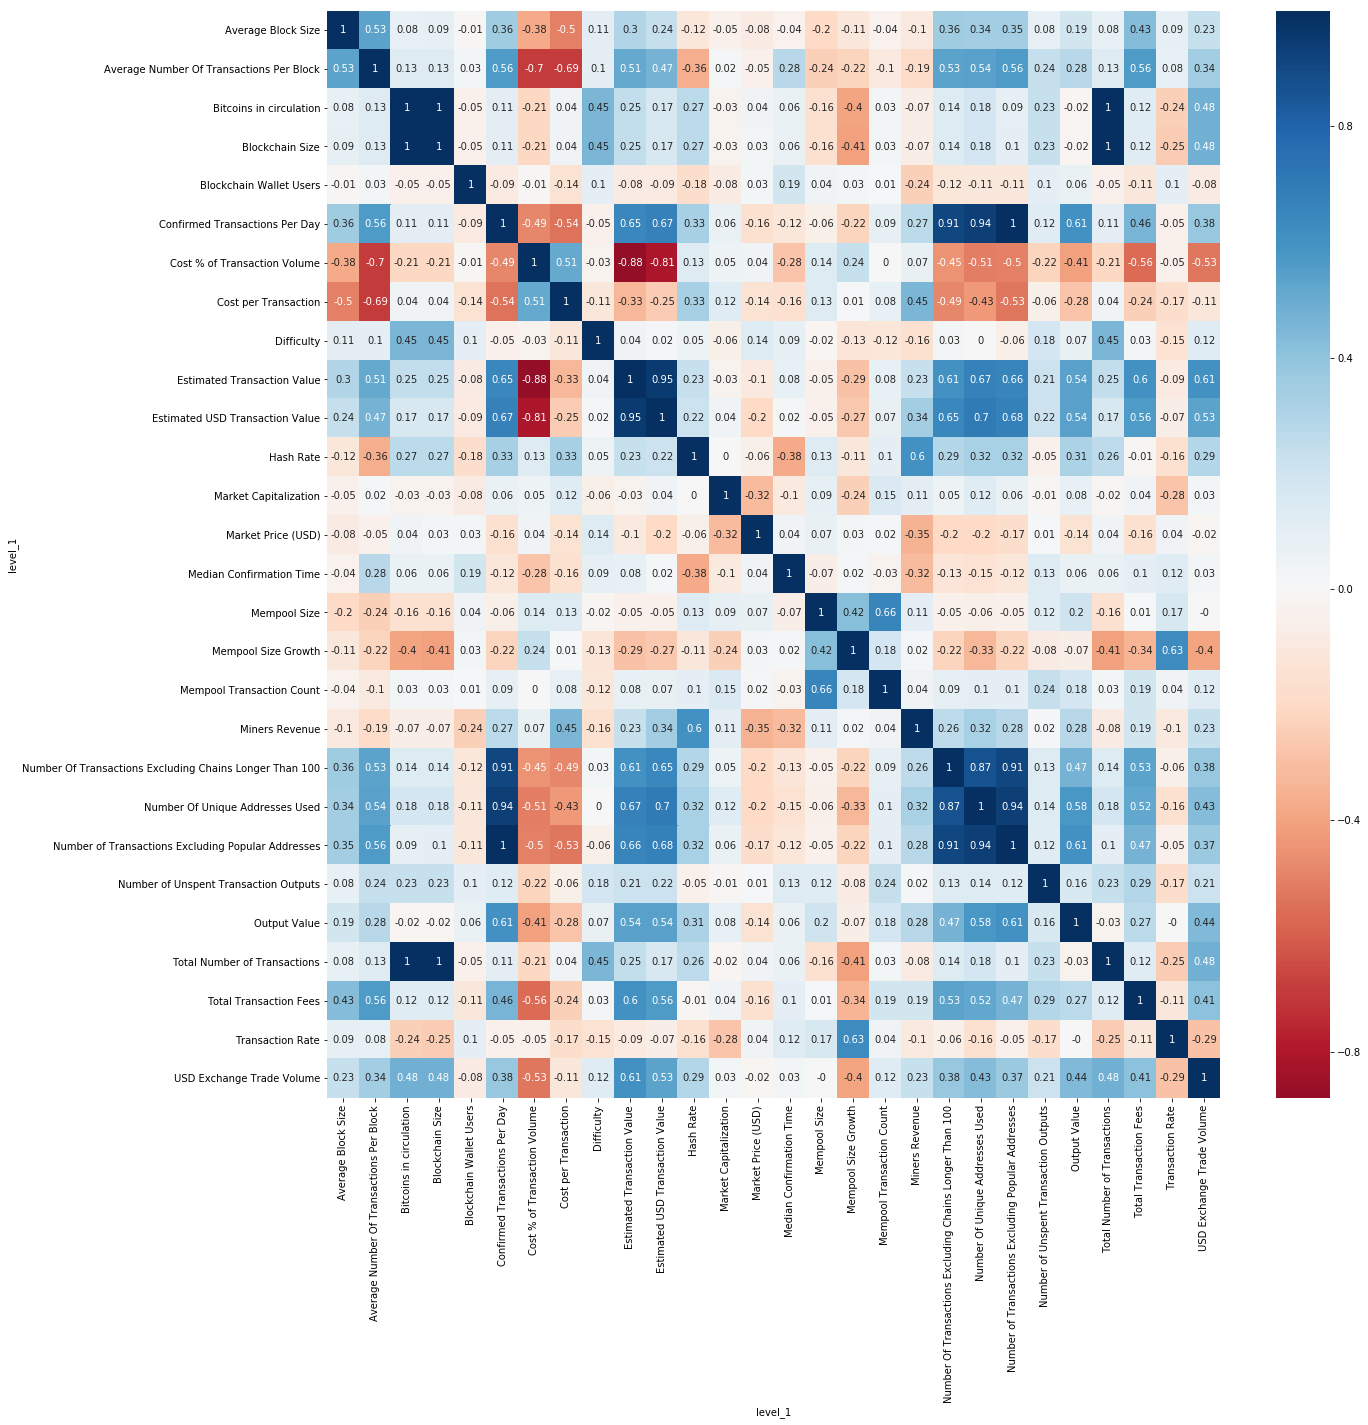

In [29]:
# Lets not forget about our friendly log transformation
window = 7
log_roll_corr = log_chart_df.rolling(window=window).corr()
# Plot a heatmap of ALL the log data against Market Price (USD)
all_log_roll_corr_df = log_roll_corr.reset_index().pivot(index='level_0', columns='level_1').dropna()
plt.figure(figsize=(20,20))
sns.heatmap(round(all_log_roll_corr_df['Market Price (USD)'].corr(),2), annot=True, center=0, cmap="RdBu");

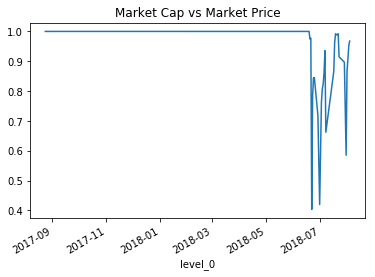

In [33]:
# The Market Cap vs Market Price Correlation looked suspicious on the heat map. 
all_log_roll_corr_df['Market Price (USD)']['Market Capitalization'].plot(title='Market Cap vs Market Price');

Not entirely sure what that divet is from, but it doesn't matter because we won't be using Market Cap

## Data Exploration: Quantitative Features Linear Regression
Below we'll examine our features using another plotting method called linear regression. This technique assumes a normal distribution and for our purposes it's not necessary. However, if we're aware of our assumptions we can use it for cursory interpretations.

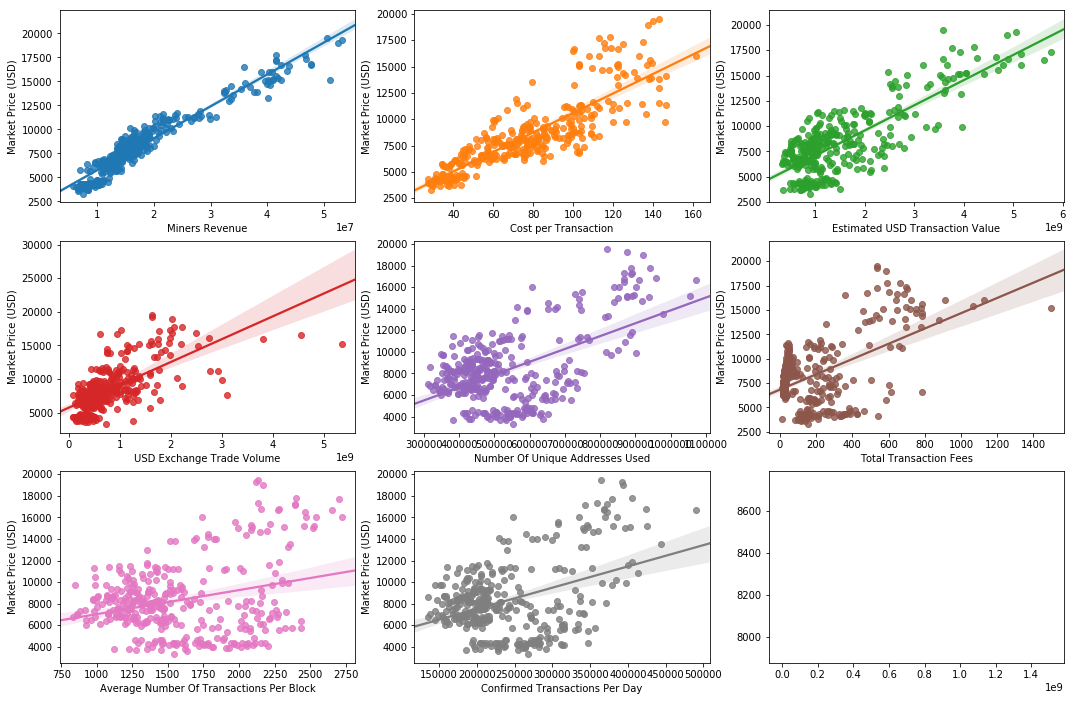

In [36]:
# PLotting linear Regression
fig, ax = plt.subplots(round(len(features) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features) - 1:
        sns.regplot(x=features[i+1],y='Market Price (USD)', data=chart_df[features], ax=ax)
        

# Conclusion:
We are not really done here, but for now I think this is a good place to stop. Our EDA is getting a little too lengthy and our results are slim. There is still a lot we can do, however I am limited by my own inexperience. All feedback is welcomed, if you hate it or love it, or have a better way of doing things let me know! This was mostly an exercise for me and I am happy to share my work with others for whatever purpose it may serve. Just take everything with a grain of salt. I'm still a noob.

This was my first time-series EDA and I went through many iterations as I learned new techniques and different approaches. I was hoping for better results, but without expanding my dataset this is all I could come up with for now. 

You can read some of my notes below if you want to capture my insights.

# Notes

## [Miners Revenue](https://www.blockchain.com/charts/miners-revenue)
Total value of coinbase block rewards and transaction fees paid to miners.


Top Correlations:
* [Market Price USD](https://www.blockchain.com/charts/market-price) (.96) - Average USD Market Price across major exchanges.
* [Estimated USD Transaction Value](https://www.blockchain.com/charts/estimated-transaction-volume-usd) (.86) - The Estimated Transaction Value in USD value.
* [Cost Per Transaction](https://www.blockchain.com/charts/cost-per-transaction) (.79) - Miners Revenue divided by the number of transactions.

Notes:

Market Price can be explained as miners are rewarded in BTC for their services, so the higher the price of BTC the more revenue miners make. This feature was built into bitcoins protocol to incentivize people. Naturally as the price of bitcoin increases, we should see more miners. However this effect must be studied more. We can examine the Hash Rate of bitcoins blockchain, a cumulative amount of computer power which essentially shows us the amount of miners. We can see a strong positive trend even as the price of bitcoin has been falling, effectively lowering Miner Revenue.

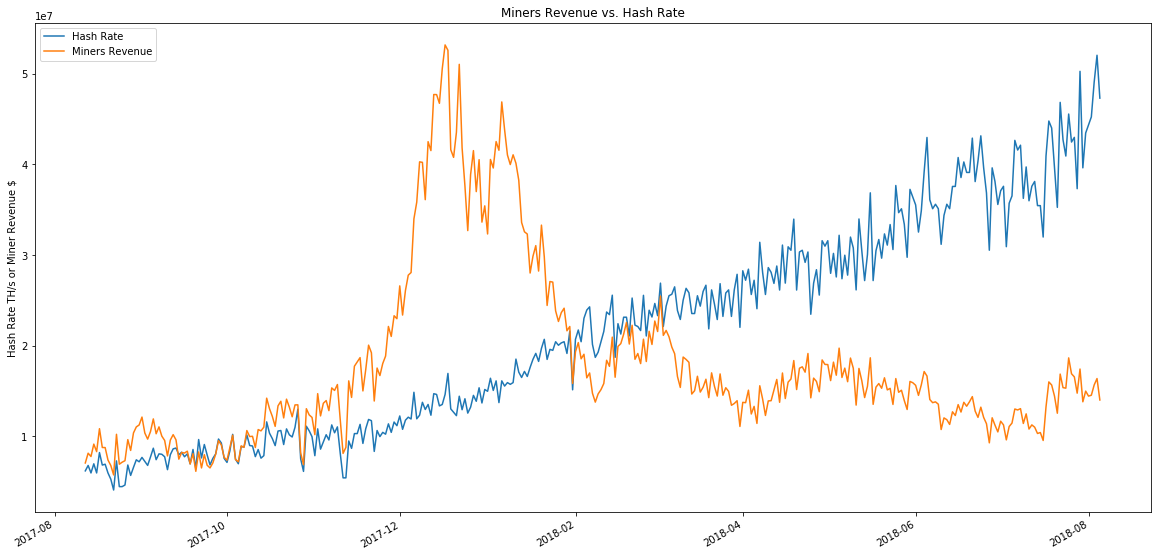

In [86]:
# Both y axis end up being on the same scale. Where one is measured in TH/s (Trillions of Hashes/second) and the other is $USD
plt.ylabel('Hash Rate TH/s or Miner Revenue $')
chart_df['Hash Rate'].plot(figsize=(20,10), title='Miners Revenue vs. Hash Rate', legend=True)
chart_df['Miners Revenue'].plot(legend=True);

So we can clearly see that, more and more resources are being allocated for mining bitcoin, even while revenues have been low! Bitcoins price decline has not visibly had a negative effect on the state of its network. In fact more people have started mining bitcoin regardless of its price. It would be interesting to see at which price miners start to lose money. This would give us a good baseline for a [value investing approach](https://www.investopedia.com/terms/v/valueinvesting.asp). It may be also that many new miners began after the hype of last year and are now exhibiting sunk cost behavior. We don't have enough data to speculate on this though.

**Further Analysis to be done:**
* Analyzing Bitcoins Intrinsic Value. In a later study we can look at metrics like Metcalfs law, Miners Overhead/Revenue and other factors determining Bitcoins Intrinsic Value.




## [Cost Per Transaction](https://www.blockchain.com/charts/cost-per-transaction)
Miners Revenue divided by the number of transactions.


Top Correlations:
* [Market Price USD](https://www.blockchain.com/charts/market-price) (.85) - Average USD Market Price across major exchanges.
* [Miners Revenue](https://www.blockchain.com/charts/miners-revenue) (.79) - Total value of coinbase block rewards and transaction fees paid to miners.

Notes:

Market Price relates to Cost Per Transaction (CPT) because CPT is a derivative of Miners Revenue. Thus making it a redundant feature. We should detach Miners Revenue and look at the Confirmed Transactions Per Day column to see if we can include it in our features.


In [456]:
CTPD = corr_df['Confirmed Transactions Per Day']
CTPD[CTPD > 0.5].sort_values(ascending=False)[1:]

Number of Transactions Excluding Popular Addresses         0.998559
Number Of Unique Addresses Used                            0.963858
Number Of Transactions Excluding Chains Longer Than 100    0.936748
Average Number Of Transactions Per Block                   0.860990
Estimated Transaction Value                                0.762231
Estimated USD Transaction Value                            0.746474
Total Transaction Fees                                     0.701044
Output Value                                               0.671846
Average Block Size                                         0.567865
Miners Revenue                                             0.538961
Name: Confirmed Transactions Per Day, dtype: float64

Judging by these numbers, Confirmed Transactions Per Day isn't strongly correlated with Market Price USD and we can remove both our previous feature CPT and this one from our features list.

## [Estimated USD Transaction Value](https://www.blockchain.com/charts/estimated-transaction-volume-usd) 
The Estimated Transaction Value in USD value.

Top Correlations:
* [Miners Revenue](https://www.blockchain.com/charts/miners-revenue) (0.86) - Total value of coinbase block rewards and transaction fees paid to miners.
* [Number Of Unique Addresses Used](https://www.blockchain.com/charts/n-unique-addresses)(0.85) - The total number of unique addresses used on the Bitcoin blockchain.
* [Market Price USD](https://www.blockchain.com/charts/market-price) (0.80) - Average USD Market Price across major exchanges.                          
* [Total Transaction Fees(BTC)](https://www.blockchain.com/charts/transaction-fees)(0.76) - The total value of all transaction fees paid to miners in BTC.(not including the coinbase value of block rewards).
* [USD Exchange Trade Volume](https://www.blockchain.com/charts/trade-volume) (0.76)- The total USD value of trading volume on major bitcoin exchanges.
* [Confirmed Transactions Per Day](https://www.blockchain.com/charts/n-transactions)                          (0.75) - The number of daily confirmed Bitcoin transactions.
* [Number of Transactions Excluding Popular Addresses](https://www.blockchain.com/charts/n-transactions-excluding-popular)         (0.74) - The total number of Bitcoin transactions, excluding those involving any of the network's 100 most popular addresses.
* [Estimated Transaction Value(BTC)](https://www.blockchain.com/charts/estimated-transaction-volume)                                (0.68) - The total estimated value of transactions on the Bitcoin blockchain (does not include coins returned to sender as change).
* [Average Number Of Transactions Per Block](https://www.blockchain.com/charts/n-transactions-per-block)               (0.64) - The average number of transactions per block.
* [Number Of Transactions Excluding Chains Longer Than 100](https://www.blockchain.com/charts/n-transactions-excluding-chains-longer-than-100)    (0.63) - The total number of Bitcoin transactions per day excluding those part of long transaction chains. There are many legitimate reasons to create long transaction chains; however, they may also be caused by coin mixing or possible attempts to manipulate transaction volume.
* [Average Block Size](https://www.blockchain.com/charts/avg-block-size)                                       (0.54) - The average block size in MB.

This feature has a lot of correlations, but lets not get overwhelmed. There's a few things here that we can drop right off the bat. 
Miners Revenue since its already a feature, Number of Transactions Excluding... are similar to Confirmed Transactions Per day.

So that leaves us with still quite a few things to look at. 

* The **Number of Unique Addresses Used** is strongly correlated to our feature and this makes sense. Unique addresses should be generated every time you transact on the blockchain, so this doesn't necessarily mean there are more people using the blockchain, it just means there are a greater number of active users during that timeframe. The difference is subtle, but should be noted. This metric is highly correlated with volume for obvious reasons. It would be interesting to understand the transaction rates regarding each unique address. For example, how many are actually new wallets generated by new users and how many are just existing users using new addresses for privacy?

* **Market Price USD** is also strongly Correlated. This is interesting and may prove to be very useful for us. We can use the blockchain's transaction volume to give us a leading edge against the market by at least 10 minutes (block confirmation time). Essentially, **<u>if we track volume on the blockchain *BEFORE* it gets to major exchanges we can be ready for a correlated move in Market Price.<u>**


* **Total Transaction Fees** is another interesting correlation, because it's based in BTC. Mathematically, there is probably some fractional linear relationship explaining this. 

* **USD Exchange Trade Volume** is similar to our feature, I'm a little surprised it's not more correlated with Estimated USD Transaction Value. Of course, not all transactions happen on major exchanges, and there are lots of minor exchanges. Coin mixing services, and normal peer to peer services can account for a large amount of volume as well. Which makes me wonder how many people are actually using bitcoin as a payment. According to this correlation there are some, but we have a very rough idea. Apart from that, we can also think of this metric as a good comparison when we are trying to detect volume anomalies across the blockchain.


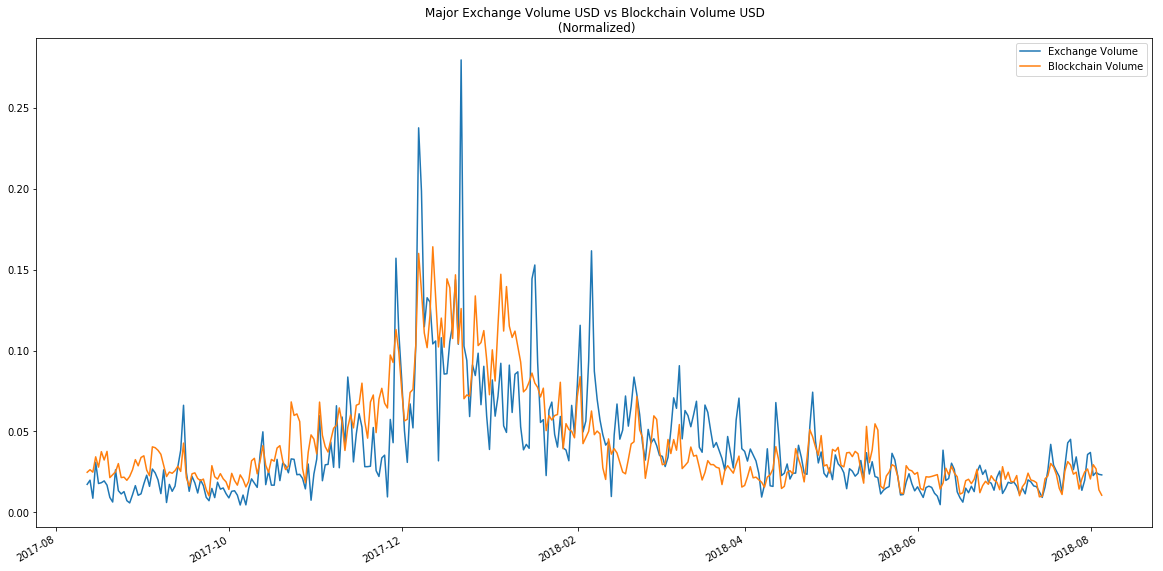

In [87]:
from sklearn.preprocessing import normalize

normalized_volumes = normalize(chart_df[['USD Exchange Trade Volume','Estimated USD Transaction Value']], axis=0)
normalized_df = pd.DataFrame(normalized_volumes, index=chart_df.index)
normalized_df.plot(figsize=(20,10)).legend(["Exchange Volume","Blockchain Volume"])
plt.title("Major Exchange Volume USD vs Blockchain Volume USD\n (Normalized)");


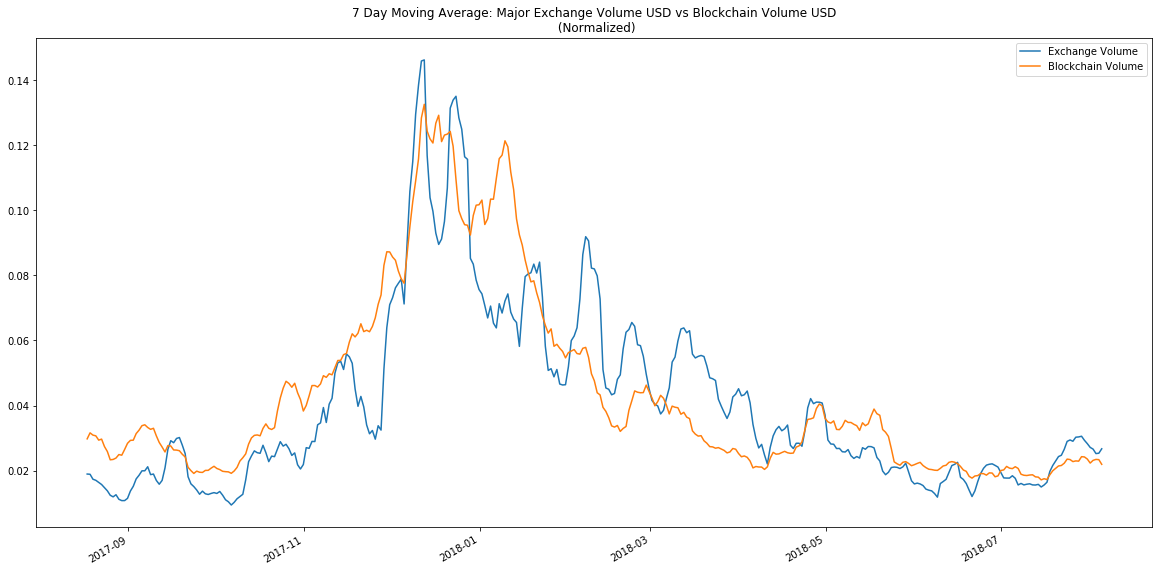

In [91]:
# Smoothing out the charts with a 7 day rolling average.
normalized_df = pd.DataFrame(normalized_volumes, index=chart_df.index).rolling(window=7).mean()
normalized_df.plot(figsize=(20,10)).legend(["Exchange Volume","Blockchain Volume"])
plt.title("7 Day Moving Average: Major Exchange Volume USD vs Blockchain Volume USD\n (Normalized)");

That's better.
Notice How the Blockchain volume tends to *lead* Exchange Volume?

Let's examine this against our market price chart and see if we can gain any other insights.

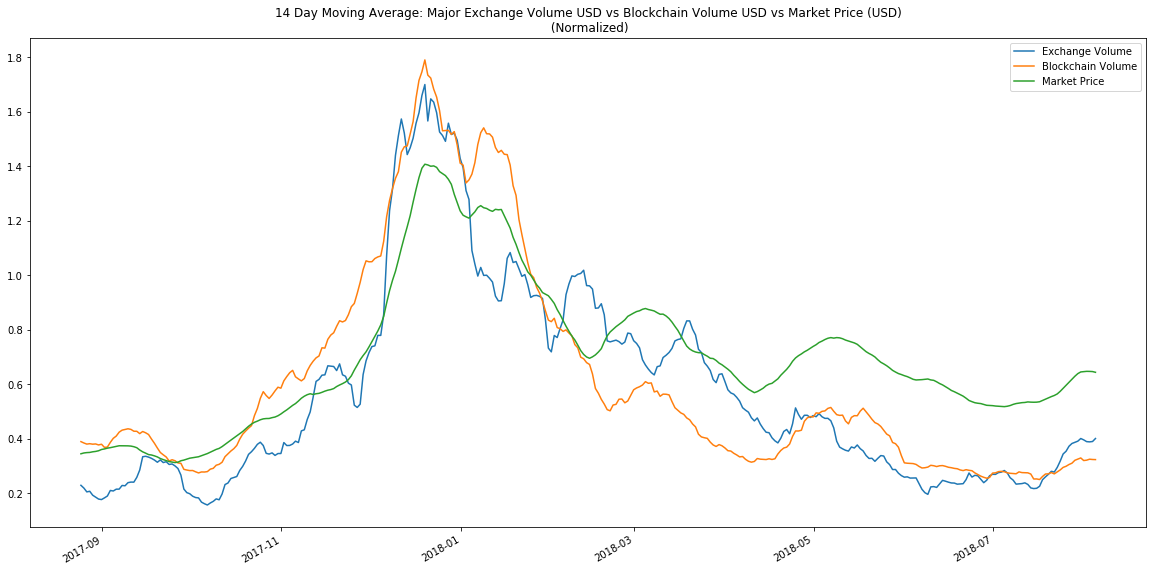

In [98]:
normalized_volumes = normalize(chart_df[['USD Exchange Trade Volume','Estimated USD Transaction Value', 'Market Price (USD)']], axis=0)
normalized_df = pd.DataFrame(normalized_volumes, index=chart_df.index)
normalized_df.rolling(window=14).sum().plot(figsize=(20,10)).legend(["Exchange Volume","Blockchain Volume", 'Market Price']);
plt.title("14 Day Moving Average: Major Exchange Volume USD vs Blockchain Volume USD vs Market Price (USD)\n (Normalized)");